## Imports

In [3]:
import pandas as pd
import swifter
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
from glob import glob
import lightgbm as lgb
import random as r
import numpy as np
from tqdm import tqdm

import json
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from geopy.distance import distance
from functools import lru_cache

sns.set_theme()
tqdm.pandas()
swifter.register_modin()

## Constants

In [4]:
DATA_BASEDIR = Path("data")
TRAIN_DATA = DATA_BASEDIR / "train_data" / "train_data"
TEST_DATA = DATA_BASEDIR / "test_data" / "test_data"

## Utilities

In [5]:
def persist_to_json(file_name):

    def decorator(original_func):

        try:
            cache = json.load(open(file_name, 'r'))
        except (IOError, ValueError):
            cache = {}

        def new_func(*args):
            param = str(json.dumps(args))
            if param not in cache:
                cache[param] = original_func(*args)
                json.dump(cache, open(file_name, 'w'))
            return cache[param]

        return new_func

    return decorator

In [6]:
def persist_to_npy(file_name):
    def decorator(original_func):
        try:
            if file_name[-4:] != ".npy":
                cache = np.load(f"{file_name}.npy", allow_pickle=True)[()]
            else:
                cache = np.load(file_name, allow_pickle=True)[()]
        except (IOError, ValueError):
            cache = {}

        def inner(*args):
            param = str(json.dumps(args))
            if param not in cache:
                cache[param] = original_func(*args)
                np.save(file_name, cache)
            return cache[param]

        return inner

    return decorator


In [7]:
def read_part(fn):
    df = pd.read_csv(fn)
    pth = Path(fn).stem
    part = pth.split("_")[0]
    df["part"] = part
    return df
        
def read_tag(tag, basedir):
    return pd.concat(map(read_part, glob(str(basedir / f"[0-9]_{tag}.csv"))))

##  Base data

In [23]:
train_schedule = read_tag("schedule", TRAIN_DATA)
train_weather = read_tag("weather_data", TRAIN_DATA)
train_data = read_tag("data", TRAIN_DATA)

test_schedule = read_tag("schedule", TEST_DATA)
test_weather = read_tag("weather_data", TEST_DATA)
test_data = read_tag("data", TEST_DATA)

arp = pd.read_csv("data/airports.csv").set_index("index").to_dict()
train_df = pd.read_csv(DATA_BASEDIR / "train.csv")
test_df = pd.read_csv(DATA_BASEDIR / "test.csv")


In [34]:
pd.to_datetime(train_weather.start_time, unit="s").dt.isocalendar()

,year,week,day
0,1971,44,5
1,1971,44,5
2,1971,44,5
3,1971,44,5
4,1971,44,5
...,...,...,...
47145,1970,44,6
47146,1970,44,6
47147,1970,44,6
47148,1970,44,6


In [9]:

weather = pd.concat([test_weather, train_weather], ignore_index=True) 
weather["part"] = weather["part"].astype(np.int8)

In [10]:
relevant_arps = (
    set(train_schedule.departure_air.unique())
    | set(train_schedule.arrival_air.unique())
    | set(test_schedule.departure_air.unique())
    | set(test_schedule.arrival_air.unique())
)

In [11]:
schedule = pd.concat(
    [train_schedule.set_index("flight_id"), test_schedule.set_index("flight_id")]
)

### Helper dicts

In [14]:
def to_points(data, stage):
    data = (
        data.set_index(["query_id", "suggestion_id"])
        .loc[:, [f"{stage}_lat", f"{stage}_long"]]
        .to_dict()
    )
    keys = data[f"{stage}_lat"].keys()
    return {
        str(key): (data[f"{stage}_lat"][key], data[f"{stage}_long"][key])
        for key in keys
    }

In [15]:
start_points_by_split = {
    "test": to_points(test_df, "start"),
    "train": to_points(train_df, "start")
}

In [16]:
end_points_by_split = {
    "test": to_points(test_df, "end"),
    "train": to_points(train_df, "end")
}

In [17]:
arp_coor = {
    arp_name: (arp["Latitude"][arp_name], arp["Longitude"][arp_name])
    for arp_name in relevant_arps
}

In [18]:
flights = (
    schedule.groupby("departure_air")
    .agg(arrival=("arrival_air", "unique"))
    .to_dict()["arrival"]
)

In [19]:
flight_distance = defaultdict(dict)
for departure, destinations in flights.items():
    for destination in destinations:
        flight_distance[departure][destination] = distance(
            arp_coor[departure], arp_coor[destination],
        ).m

In [20]:
suggested_itinerary_by_split = {
    split: {
        str(key): list(map(int, json.loads(fs)))
        for key, fs in df.set_index(["query_id", "suggestion_id"])
        .flights.to_dict()
        .items()
    }
    for split, df in [("test", test_df), ("train", train_df)]
}

In [21]:
route_by_id = schedule.loc[
    :,
    [
        "departure_air",
        "arrival_air",
        "departure_planned_time",
        "arrival_planned_time",
        "part",
    ],
].to_dict()

In [22]:
route_by_id

{'departure_air': {16132315: 'GUM',
  16132377: 'GUM',
  16150575: 'EWR',
  16150578: 'EWR',
  16151540: 'JFK',
  16151545: 'BOS',
  16151563: 'JFK',
  16151567: 'JFK',
  16151682: 'JFK',
  16151744: 'JFK',
  16151768: 'JFK',
  16151796: 'BOS',
  16152419: 'BOS',
  16152461: 'BOS',
  16152514: 'JFK',
  16152519: 'JFK',
  16152739: 'JFK',
  16152763: 'JFK',
  16152805: 'JFK',
  16152821: 'JFK',
  16153148: 'ATL',
  16153149: 'ATL',
  16153150: 'BOS',
  16153165: 'BOS',
  16153651: 'EWR',
  16153708: 'JFK',
  16153727: 'CLT',
  16153732: 'JFK',
  16153757: 'CLT',
  16153758: 'EWR',
  16153800: 'JFK',
  16153805: 'JFK',
  16153883: 'SEA',
  16153892: 'SFO',
  16153909: 'JFK',
  16153910: 'SJC',
  16153912: 'PHX',
  16153917: 'LAX',
  16153920: 'EWR',
  16153937: 'JFK',
  16153959: 'SFO',
  16153963: 'LAX',
  16153966: 'JFK',
  16153968: 'JFK',
  16153996: 'SEA',
  16154009: 'PHX',
  16154016: 'SJC',
  16154084: 'EWR',
  16154206: 'JFK',
  16154236: 'SMF',
  16154243: 'OAK',
  16154256: 'S

In [18]:
    def get_key(row):
    return str((row["query_id"], row["suggestion_id"]))

In [19]:
@persist_to_file("transfer_distance_by_stage_and_split.json")
def get_transfer_distance_by_stage_and_split():
    transfer_distance_by_stage_and_split = {}
    stages = ["departure", "arrival"]

    for stage in stages:
        points_by_split = (
            start_points_by_split if stage == "departure" else end_points_by_split
        )
        with tqdm(
            total=sum(len(points) for split, points in points_by_split.items()),
            desc=stage,
        ) as pbar:
            transfer_distance_by_split = {}
            for split, points in points_by_split.items():
                transfer_distance = {}
                for key, point in points.items():
                    routes = suggested_itinerary_by_split[split][key]

                    if routes:
                        flight_id = routes[0] if stage == "departure" else routes[-1]
                        air = route_by_id[f"{stage}_air"][flight_id]
                        val = distance(arp_coor[air], point).m
                    else:
                        val = 0
                    transfer_distance[key] = val
                    pbar.update()
                transfer_distance_by_split[split] = transfer_distance
            transfer_distance_by_stage_and_split[stage] = transfer_distance_by_split
    return transfer_distance_by_stage_and_split

In [20]:
transfer_distance_by_stage_and_split = get_transfer_distance_by_stage_and_split()

In [21]:
@lru_cache(maxsize=None)
def route_distance(key, split):
    ids = suggested_itinerary_by_split[split][key]
    if not ids:
        return 0.0

    departure_airs = [route_by_id["departure_air"][id_] for id_ in ids]
    arrival_airs = [route_by_id["arrival_air"][id_] for id_ in ids]

    return sum(
        flight_distance[departure_air][arrival_air]
        for departure_air, arrival_air in zip(departure_airs, arrival_airs)
    )

In [20]:
@lru_cache(maxsize=None)
def time_in_air(key, split):
    ids = suggested_itinerary_by_split[split][key]
    if not ids:
        return 0.0
    departure_times = np.asarray(
        list(map(lambda id_: route_by_id["departure_planned_time"][id_], ids))
    )
    arrival_times = np.asarray(
        list(map(lambda id_: route_by_id["arrival_planned_time"][id_], ids))
    )
    if any(arrival_times < departure_times):
        raise ValueError("The planned arrival time is less than the departure time")
    return (arrival_times - departure_times).sum()

In [21]:
@lru_cache(maxsize=None)
def wasted_time(key, split):
    ids = suggested_itinerary_by_split[split][key]

    if not ids:
        return 0.0

    wait = 0
    now = route_by_id["departure_planned_time"][ids[0]]
    for flight_id in ids:
        departure_time = route_by_id["departure_planned_time"][flight_id]
        arrival_time = route_by_id["arrival_planned_time"][flight_id]
        wait += departure_time - now
        now = arrival_time

    return wait

In [22]:
@lru_cache(maxsize=None)
def hops(key, split):
    return len(suggested_itinerary_by_split[split][key])
    

In [23]:
test_row = test_df.iloc[0]

In [24]:
def compute_time_in_air(row, split):
    key = get_key(row)
    return time_in_air(key, split)
    

In [25]:
compute_time_in_air(test_row, "test")

13200

In [26]:
def compute_wasted_time(row, split):
    key = get_key(row)
    return wasted_time(key, split)


In [27]:
compute_wasted_time(test_row, "test")

112260

In [28]:
def compute_hops(row, split):
    key = get_key(row)
    return hops(key, split)
    

In [29]:
compute_hops(test_row, "test")

2

In [30]:
def compute_transfer_distance_on_departure(row, split):
    key = get_key(row)
    return transfer_distance_by_stage_and_split["departure"][split][key]

In [31]:
compute_transfer_distance_on_departure(test_row, "test")

142054.5511412879

In [32]:
def compute_prep_time(row, split):
    key = get_key(row)

    routes = suggested_itinerary_by_split[split][key]
    if not routes:
        return 0.0

    flight_id = routes[0]
    return route_by_id["departure_planned_time"][flight_id] - row["start_time"]
    

In [33]:
compute_prep_time(test_row, "test")

10818

In [34]:
def compute_transfer_distance_on_arrival(row, split):
    key = get_key(row)
    return transfer_distance_by_stage_and_split["arrival"][split][key]


In [35]:
compute_transfer_distance_on_arrival(test_row, "test")

228824.4598524753

In [36]:
def compute_route_distance(row, split):
    key = get_key(row)
    return route_distance(key, split)

In [37]:
compute_route_distance(test_row, "test")

1306536.7791664023

In [38]:
def compute_target_distance(row):
    start_lat, start_lon, end_lat, end_lon = (
        row["start_lat"],
        row["start_long"],
        row["end_lat"],
        row["end_long"],
    )

    return distance((start_lat, start_lon), (end_lat, end_lon)).m

In [39]:
compute_target_distance(test_row)

1601027.667477994

In [40]:
def compute_total_time(row, split):
    key = get_key(row)
    
    if not suggested_itinerary_by_split[split][key]:
        return row["hypothetical_time_on_foot_s"]
    
    return row["planned_total_time_by_air_s"]
    

## Weather models


In [42]:
X_weather = weather.drop(["type", "level"], axis=1)
weather_type = weather["type"]
weather_level = weather["level"]

In [43]:
X_weather

,start_time,end_time,latitude,longtitude,part
0,136081340,136087040,42.6973,-73.1696,6
1,136085120,136087040,39.7719,-94.9097,6
2,136085480,136087040,39.4944,-121.6222,6
3,136067960,136087100,35.0147,-80.6242,6
4,136084640,136087100,48.9318,-95.3405,6
...,...,...,...,...,...
982556,26215760,26217920,32.3003,-86.4061,1
982557,26214260,26217980,41.8065,-107.1952,1
982558,26214260,26217980,41.7297,-107.7252,1
982559,26216840,26218040,48.7525,-96.9376,1


In [43]:
msk = np.random.rand(len(X_weather)) < 0.8

X_weather_train, y_type_train, y_level_train = (
    X_weather.loc[msk],
    weather_type.loc[msk],
    weather_level.loc[msk],
)
X_weather_val, y_type_val, y_level_val = (
    X_weather.loc[~msk],
    weather_type.loc[~msk],
    weather_level.loc[~msk],
)

In [53]:
%%time
type_clf = lgb.LGBMClassifier(n_estimators=1000, reg_lambda=1.0, colsample_bytree=0.8)
type_clf.fit(
    X_weather_train,
    y_type_train,
    eval_set=[(X_weather_val, y_type_val)],
    early_stopping_rounds=1000,
    eval_metric=["auc_mu", "multi_logloss"],
)

[1]	valid_0's auc_mu: 0.806663	valid_0's multi_logloss: 1.05271
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc_mu: 0.842707	valid_0's multi_logloss: 1.01417
[3]	valid_0's auc_mu: 0.854106	valid_0's multi_logloss: 0.985925
[4]	valid_0's auc_mu: 0.863987	valid_0's multi_logloss: 0.962626
[5]	valid_0's auc_mu: 0.867787	valid_0's multi_logloss: 0.943467
[6]	valid_0's auc_mu: 0.870888	valid_0's multi_logloss: 0.929169
[7]	valid_0's auc_mu: 0.874556	valid_0's multi_logloss: 0.917099
[8]	valid_0's auc_mu: 0.879132	valid_0's multi_logloss: 0.905012
[9]	valid_0's auc_mu: 0.881798	valid_0's multi_logloss: 0.893268
[10]	valid_0's auc_mu: 0.885293	valid_0's multi_logloss: 0.882658
[11]	valid_0's auc_mu: 0.887854	valid_0's multi_logloss: 0.874147
[12]	valid_0's auc_mu: 0.889307	valid_0's multi_logloss: 0.866536
[13]	valid_0's auc_mu: 0.890945	valid_0's multi_logloss: 0.859388
[14]	valid_0's auc_mu: 0.892167	valid_0's multi_logloss: 0.853289
[15]	valid_0's auc_mu: 0

[125]	valid_0's auc_mu: 0.938706	valid_0's multi_logloss: 0.70825
[126]	valid_0's auc_mu: 0.93883	valid_0's multi_logloss: 0.707602
[127]	valid_0's auc_mu: 0.938895	valid_0's multi_logloss: 0.707042
[128]	valid_0's auc_mu: 0.939019	valid_0's multi_logloss: 0.706527
[129]	valid_0's auc_mu: 0.93913	valid_0's multi_logloss: 0.705786
[130]	valid_0's auc_mu: 0.939185	valid_0's multi_logloss: 0.705149
[131]	valid_0's auc_mu: 0.939427	valid_0's multi_logloss: 0.704597
[132]	valid_0's auc_mu: 0.939511	valid_0's multi_logloss: 0.704242
[133]	valid_0's auc_mu: 0.939578	valid_0's multi_logloss: 0.703952
[134]	valid_0's auc_mu: 0.939643	valid_0's multi_logloss: 0.703686
[135]	valid_0's auc_mu: 0.939696	valid_0's multi_logloss: 0.703482
[136]	valid_0's auc_mu: 0.939757	valid_0's multi_logloss: 0.703108
[137]	valid_0's auc_mu: 0.939878	valid_0's multi_logloss: 0.702723
[138]	valid_0's auc_mu: 0.940028	valid_0's multi_logloss: 0.702273
[139]	valid_0's auc_mu: 0.940189	valid_0's multi_logloss: 0.70184

[248]	valid_0's auc_mu: 0.947928	valid_0's multi_logloss: 0.665831
[249]	valid_0's auc_mu: 0.947996	valid_0's multi_logloss: 0.665548
[250]	valid_0's auc_mu: 0.948108	valid_0's multi_logloss: 0.665244
[251]	valid_0's auc_mu: 0.948147	valid_0's multi_logloss: 0.665077
[252]	valid_0's auc_mu: 0.948219	valid_0's multi_logloss: 0.664745
[253]	valid_0's auc_mu: 0.948254	valid_0's multi_logloss: 0.664525
[254]	valid_0's auc_mu: 0.948257	valid_0's multi_logloss: 0.664245
[255]	valid_0's auc_mu: 0.948316	valid_0's multi_logloss: 0.663981
[256]	valid_0's auc_mu: 0.948375	valid_0's multi_logloss: 0.663672
[257]	valid_0's auc_mu: 0.94842	valid_0's multi_logloss: 0.663509
[258]	valid_0's auc_mu: 0.948512	valid_0's multi_logloss: 0.66314
[259]	valid_0's auc_mu: 0.948537	valid_0's multi_logloss: 0.662951
[260]	valid_0's auc_mu: 0.948578	valid_0's multi_logloss: 0.662728
[261]	valid_0's auc_mu: 0.948588	valid_0's multi_logloss: 0.662557
[262]	valid_0's auc_mu: 0.948647	valid_0's multi_logloss: 0.6622

[371]	valid_0's auc_mu: 0.953131	valid_0's multi_logloss: 0.638017
[372]	valid_0's auc_mu: 0.953142	valid_0's multi_logloss: 0.637864
[373]	valid_0's auc_mu: 0.953161	valid_0's multi_logloss: 0.637676
[374]	valid_0's auc_mu: 0.953185	valid_0's multi_logloss: 0.637582
[375]	valid_0's auc_mu: 0.953208	valid_0's multi_logloss: 0.637475
[376]	valid_0's auc_mu: 0.953229	valid_0's multi_logloss: 0.637214
[377]	valid_0's auc_mu: 0.953256	valid_0's multi_logloss: 0.636949
[378]	valid_0's auc_mu: 0.95327	valid_0's multi_logloss: 0.636783
[379]	valid_0's auc_mu: 0.953282	valid_0's multi_logloss: 0.63658
[380]	valid_0's auc_mu: 0.9533	valid_0's multi_logloss: 0.636497
[381]	valid_0's auc_mu: 0.953287	valid_0's multi_logloss: 0.636332
[382]	valid_0's auc_mu: 0.953297	valid_0's multi_logloss: 0.63616
[383]	valid_0's auc_mu: 0.953352	valid_0's multi_logloss: 0.635889
[384]	valid_0's auc_mu: 0.953382	valid_0's multi_logloss: 0.635709
[385]	valid_0's auc_mu: 0.953394	valid_0's multi_logloss: 0.635513


[494]	valid_0's auc_mu: 0.955828	valid_0's multi_logloss: 0.619483
[495]	valid_0's auc_mu: 0.955854	valid_0's multi_logloss: 0.619339
[496]	valid_0's auc_mu: 0.955871	valid_0's multi_logloss: 0.619251
[497]	valid_0's auc_mu: 0.955885	valid_0's multi_logloss: 0.619165
[498]	valid_0's auc_mu: 0.955889	valid_0's multi_logloss: 0.618999
[499]	valid_0's auc_mu: 0.955915	valid_0's multi_logloss: 0.61889
[500]	valid_0's auc_mu: 0.955946	valid_0's multi_logloss: 0.618776
[501]	valid_0's auc_mu: 0.955956	valid_0's multi_logloss: 0.618686
[502]	valid_0's auc_mu: 0.955971	valid_0's multi_logloss: 0.618543
[503]	valid_0's auc_mu: 0.956009	valid_0's multi_logloss: 0.618362
[504]	valid_0's auc_mu: 0.956011	valid_0's multi_logloss: 0.618272
[505]	valid_0's auc_mu: 0.956035	valid_0's multi_logloss: 0.618191
[506]	valid_0's auc_mu: 0.956048	valid_0's multi_logloss: 0.618096
[507]	valid_0's auc_mu: 0.956052	valid_0's multi_logloss: 0.617997
[508]	valid_0's auc_mu: 0.956067	valid_0's multi_logloss: 0.617

[617]	valid_0's auc_mu: 0.957732	valid_0's multi_logloss: 0.606368
[618]	valid_0's auc_mu: 0.957742	valid_0's multi_logloss: 0.606313
[619]	valid_0's auc_mu: 0.957765	valid_0's multi_logloss: 0.606253
[620]	valid_0's auc_mu: 0.957804	valid_0's multi_logloss: 0.606143
[621]	valid_0's auc_mu: 0.95781	valid_0's multi_logloss: 0.606049
[622]	valid_0's auc_mu: 0.957808	valid_0's multi_logloss: 0.605961
[623]	valid_0's auc_mu: 0.957813	valid_0's multi_logloss: 0.605882
[624]	valid_0's auc_mu: 0.957827	valid_0's multi_logloss: 0.605748
[625]	valid_0's auc_mu: 0.95783	valid_0's multi_logloss: 0.605661
[626]	valid_0's auc_mu: 0.95785	valid_0's multi_logloss: 0.605591
[627]	valid_0's auc_mu: 0.957877	valid_0's multi_logloss: 0.605495
[628]	valid_0's auc_mu: 0.957883	valid_0's multi_logloss: 0.605399
[629]	valid_0's auc_mu: 0.957899	valid_0's multi_logloss: 0.605299
[630]	valid_0's auc_mu: 0.95791	valid_0's multi_logloss: 0.605221
[631]	valid_0's auc_mu: 0.957924	valid_0's multi_logloss: 0.605135

[740]	valid_0's auc_mu: 0.959396	valid_0's multi_logloss: 0.594921
[741]	valid_0's auc_mu: 0.959409	valid_0's multi_logloss: 0.594852
[742]	valid_0's auc_mu: 0.95943	valid_0's multi_logloss: 0.59472
[743]	valid_0's auc_mu: 0.959431	valid_0's multi_logloss: 0.594624
[744]	valid_0's auc_mu: 0.959443	valid_0's multi_logloss: 0.594527
[745]	valid_0's auc_mu: 0.959459	valid_0's multi_logloss: 0.594481
[746]	valid_0's auc_mu: 0.959471	valid_0's multi_logloss: 0.594427
[747]	valid_0's auc_mu: 0.959484	valid_0's multi_logloss: 0.594325
[748]	valid_0's auc_mu: 0.959492	valid_0's multi_logloss: 0.594249
[749]	valid_0's auc_mu: 0.959497	valid_0's multi_logloss: 0.594201
[750]	valid_0's auc_mu: 0.959521	valid_0's multi_logloss: 0.594133
[751]	valid_0's auc_mu: 0.959529	valid_0's multi_logloss: 0.594021
[752]	valid_0's auc_mu: 0.959535	valid_0's multi_logloss: 0.59392
[753]	valid_0's auc_mu: 0.959548	valid_0's multi_logloss: 0.593867
[754]	valid_0's auc_mu: 0.959568	valid_0's multi_logloss: 0.59376

[863]	valid_0's auc_mu: 0.960379	valid_0's multi_logloss: 0.586077
[864]	valid_0's auc_mu: 0.960384	valid_0's multi_logloss: 0.586023
[865]	valid_0's auc_mu: 0.960375	valid_0's multi_logloss: 0.585966
[866]	valid_0's auc_mu: 0.96038	valid_0's multi_logloss: 0.585921
[867]	valid_0's auc_mu: 0.960385	valid_0's multi_logloss: 0.585851
[868]	valid_0's auc_mu: 0.960392	valid_0's multi_logloss: 0.585817
[869]	valid_0's auc_mu: 0.960407	valid_0's multi_logloss: 0.585721
[870]	valid_0's auc_mu: 0.960415	valid_0's multi_logloss: 0.585669
[871]	valid_0's auc_mu: 0.960423	valid_0's multi_logloss: 0.585606
[872]	valid_0's auc_mu: 0.960432	valid_0's multi_logloss: 0.585573
[873]	valid_0's auc_mu: 0.960435	valid_0's multi_logloss: 0.585499
[874]	valid_0's auc_mu: 0.960442	valid_0's multi_logloss: 0.585452
[875]	valid_0's auc_mu: 0.960453	valid_0's multi_logloss: 0.58539
[876]	valid_0's auc_mu: 0.960452	valid_0's multi_logloss: 0.58535
[877]	valid_0's auc_mu: 0.960454	valid_0's multi_logloss: 0.58525

[986]	valid_0's auc_mu: 0.961189	valid_0's multi_logloss: 0.57936
[987]	valid_0's auc_mu: 0.961198	valid_0's multi_logloss: 0.579332
[988]	valid_0's auc_mu: 0.961212	valid_0's multi_logloss: 0.579263
[989]	valid_0's auc_mu: 0.961222	valid_0's multi_logloss: 0.579197
[990]	valid_0's auc_mu: 0.961218	valid_0's multi_logloss: 0.579176
[991]	valid_0's auc_mu: 0.96122	valid_0's multi_logloss: 0.579127
[992]	valid_0's auc_mu: 0.961237	valid_0's multi_logloss: 0.579061
[993]	valid_0's auc_mu: 0.961252	valid_0's multi_logloss: 0.579003
[994]	valid_0's auc_mu: 0.961259	valid_0's multi_logloss: 0.578992
[995]	valid_0's auc_mu: 0.961276	valid_0's multi_logloss: 0.578921
[996]	valid_0's auc_mu: 0.961275	valid_0's multi_logloss: 0.578817
[997]	valid_0's auc_mu: 0.96129	valid_0's multi_logloss: 0.578765
[998]	valid_0's auc_mu: 0.961293	valid_0's multi_logloss: 0.578707
[999]	valid_0's auc_mu: 0.961308	valid_0's multi_logloss: 0.578637
[1000]	valid_0's auc_mu: 0.961324	valid_0's multi_logloss: 0.5785

LGBMClassifier(colsample_bytree=0.8, n_estimators=1000, reg_lambda=1.0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

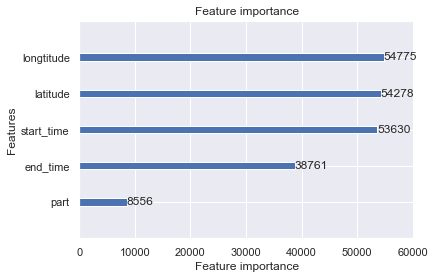

In [54]:
lgb.plot_importance(type_clf)

In [55]:
type_clf.booster_.save_model("type_clf.lgb")

In [56]:
%%time
level_clf = lgb.LGBMClassifier(n_estimators=1000, reg_lambda=1.0, colsample_bytree=0.8)
level_clf.fit(
    X_weather_train,
    y_level_train,
    eval_set=[(X_weather_val, y_level_val)],
    early_stopping_rounds=1000,
    eval_metric=["auc_mu", "multi_logloss"],
)


[1]	valid_0's auc_mu: 0.737385	valid_0's multi_logloss: 1.06663
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's auc_mu: 0.754786	valid_0's multi_logloss: 1.05805
[3]	valid_0's auc_mu: 0.759434	valid_0's multi_logloss: 1.05143
[4]	valid_0's auc_mu: 0.778329	valid_0's multi_logloss: 1.0454
[5]	valid_0's auc_mu: 0.781219	valid_0's multi_logloss: 1.04037
[6]	valid_0's auc_mu: 0.784326	valid_0's multi_logloss: 1.03602
[7]	valid_0's auc_mu: 0.785792	valid_0's multi_logloss: 1.03253
[8]	valid_0's auc_mu: 0.789715	valid_0's multi_logloss: 1.02934
[9]	valid_0's auc_mu: 0.791532	valid_0's multi_logloss: 1.0263
[10]	valid_0's auc_mu: 0.793113	valid_0's multi_logloss: 1.02359
[11]	valid_0's auc_mu: 0.794677	valid_0's multi_logloss: 1.02108
[12]	valid_0's auc_mu: 0.795801	valid_0's multi_logloss: 1.01897
[13]	valid_0's auc_mu: 0.796536	valid_0's multi_logloss: 1.01704
[14]	valid_0's auc_mu: 0.799814	valid_0's multi_logloss: 1.01472
[15]	valid_0's auc_mu: 0.801293	valid_

[125]	valid_0's auc_mu: 0.852799	valid_0's multi_logloss: 0.947215
[126]	valid_0's auc_mu: 0.852929	valid_0's multi_logloss: 0.946919
[127]	valid_0's auc_mu: 0.853045	valid_0's multi_logloss: 0.946639
[128]	valid_0's auc_mu: 0.85324	valid_0's multi_logloss: 0.94644
[129]	valid_0's auc_mu: 0.853312	valid_0's multi_logloss: 0.94621
[130]	valid_0's auc_mu: 0.853508	valid_0's multi_logloss: 0.94592
[131]	valid_0's auc_mu: 0.853582	valid_0's multi_logloss: 0.945753
[132]	valid_0's auc_mu: 0.853766	valid_0's multi_logloss: 0.945483
[133]	valid_0's auc_mu: 0.85393	valid_0's multi_logloss: 0.945225
[134]	valid_0's auc_mu: 0.854101	valid_0's multi_logloss: 0.944927
[135]	valid_0's auc_mu: 0.854253	valid_0's multi_logloss: 0.944685
[136]	valid_0's auc_mu: 0.854291	valid_0's multi_logloss: 0.94451
[137]	valid_0's auc_mu: 0.854459	valid_0's multi_logloss: 0.944187
[138]	valid_0's auc_mu: 0.854581	valid_0's multi_logloss: 0.943859
[139]	valid_0's auc_mu: 0.854787	valid_0's multi_logloss: 0.943521
[

[248]	valid_0's auc_mu: 0.868748	valid_0's multi_logloss: 0.918754
[249]	valid_0's auc_mu: 0.868811	valid_0's multi_logloss: 0.918632
[250]	valid_0's auc_mu: 0.868884	valid_0's multi_logloss: 0.918494
[251]	valid_0's auc_mu: 0.868939	valid_0's multi_logloss: 0.918328
[252]	valid_0's auc_mu: 0.869	valid_0's multi_logloss: 0.918102
[253]	valid_0's auc_mu: 0.868983	valid_0's multi_logloss: 0.918044
[254]	valid_0's auc_mu: 0.869082	valid_0's multi_logloss: 0.917874
[255]	valid_0's auc_mu: 0.869192	valid_0's multi_logloss: 0.91771
[256]	valid_0's auc_mu: 0.869298	valid_0's multi_logloss: 0.917494
[257]	valid_0's auc_mu: 0.869353	valid_0's multi_logloss: 0.917411
[258]	valid_0's auc_mu: 0.869412	valid_0's multi_logloss: 0.917173
[259]	valid_0's auc_mu: 0.869529	valid_0's multi_logloss: 0.917024
[260]	valid_0's auc_mu: 0.869588	valid_0's multi_logloss: 0.916855
[261]	valid_0's auc_mu: 0.869685	valid_0's multi_logloss: 0.916679
[262]	valid_0's auc_mu: 0.869765	valid_0's multi_logloss: 0.9165
[

[371]	valid_0's auc_mu: 0.875086	valid_0's multi_logloss: 0.901515
[372]	valid_0's auc_mu: 0.875126	valid_0's multi_logloss: 0.90139
[373]	valid_0's auc_mu: 0.875132	valid_0's multi_logloss: 0.901276
[374]	valid_0's auc_mu: 0.875137	valid_0's multi_logloss: 0.901243
[375]	valid_0's auc_mu: 0.875173	valid_0's multi_logloss: 0.901201
[376]	valid_0's auc_mu: 0.875201	valid_0's multi_logloss: 0.901137
[377]	valid_0's auc_mu: 0.875267	valid_0's multi_logloss: 0.900969
[378]	valid_0's auc_mu: 0.875327	valid_0's multi_logloss: 0.900745
[379]	valid_0's auc_mu: 0.875379	valid_0's multi_logloss: 0.90067
[380]	valid_0's auc_mu: 0.875397	valid_0's multi_logloss: 0.900572
[381]	valid_0's auc_mu: 0.875445	valid_0's multi_logloss: 0.900485
[382]	valid_0's auc_mu: 0.875492	valid_0's multi_logloss: 0.900385
[383]	valid_0's auc_mu: 0.87551	valid_0's multi_logloss: 0.900278
[384]	valid_0's auc_mu: 0.875509	valid_0's multi_logloss: 0.900164
[385]	valid_0's auc_mu: 0.875554	valid_0's multi_logloss: 0.89996

[494]	valid_0's auc_mu: 0.879163	valid_0's multi_logloss: 0.888133
[495]	valid_0's auc_mu: 0.879148	valid_0's multi_logloss: 0.888076
[496]	valid_0's auc_mu: 0.879173	valid_0's multi_logloss: 0.887946
[497]	valid_0's auc_mu: 0.879179	valid_0's multi_logloss: 0.887859
[498]	valid_0's auc_mu: 0.879181	valid_0's multi_logloss: 0.887781
[499]	valid_0's auc_mu: 0.87918	valid_0's multi_logloss: 0.887683
[500]	valid_0's auc_mu: 0.879202	valid_0's multi_logloss: 0.887602
[501]	valid_0's auc_mu: 0.879194	valid_0's multi_logloss: 0.887538
[502]	valid_0's auc_mu: 0.879231	valid_0's multi_logloss: 0.887486
[503]	valid_0's auc_mu: 0.879247	valid_0's multi_logloss: 0.887422
[504]	valid_0's auc_mu: 0.879268	valid_0's multi_logloss: 0.887337
[505]	valid_0's auc_mu: 0.87929	valid_0's multi_logloss: 0.887279
[506]	valid_0's auc_mu: 0.87929	valid_0's multi_logloss: 0.887214
[507]	valid_0's auc_mu: 0.879304	valid_0's multi_logloss: 0.887184
[508]	valid_0's auc_mu: 0.879302	valid_0's multi_logloss: 0.88711

[617]	valid_0's auc_mu: 0.882266	valid_0's multi_logloss: 0.878209
[618]	valid_0's auc_mu: 0.882283	valid_0's multi_logloss: 0.878123
[619]	valid_0's auc_mu: 0.882325	valid_0's multi_logloss: 0.878042
[620]	valid_0's auc_mu: 0.882344	valid_0's multi_logloss: 0.877958
[621]	valid_0's auc_mu: 0.882386	valid_0's multi_logloss: 0.877849
[622]	valid_0's auc_mu: 0.882387	valid_0's multi_logloss: 0.877784
[623]	valid_0's auc_mu: 0.882417	valid_0's multi_logloss: 0.877717
[624]	valid_0's auc_mu: 0.882438	valid_0's multi_logloss: 0.877624
[625]	valid_0's auc_mu: 0.882465	valid_0's multi_logloss: 0.877577
[626]	valid_0's auc_mu: 0.882486	valid_0's multi_logloss: 0.877532
[627]	valid_0's auc_mu: 0.882511	valid_0's multi_logloss: 0.877428
[628]	valid_0's auc_mu: 0.882563	valid_0's multi_logloss: 0.877327
[629]	valid_0's auc_mu: 0.882597	valid_0's multi_logloss: 0.877255
[630]	valid_0's auc_mu: 0.882584	valid_0's multi_logloss: 0.877206
[631]	valid_0's auc_mu: 0.882592	valid_0's multi_logloss: 0.87

[740]	valid_0's auc_mu: 0.884744	valid_0's multi_logloss: 0.869623
[741]	valid_0's auc_mu: 0.884769	valid_0's multi_logloss: 0.869565
[742]	valid_0's auc_mu: 0.884796	valid_0's multi_logloss: 0.869473
[743]	valid_0's auc_mu: 0.884805	valid_0's multi_logloss: 0.869415
[744]	valid_0's auc_mu: 0.884814	valid_0's multi_logloss: 0.869362
[745]	valid_0's auc_mu: 0.884833	valid_0's multi_logloss: 0.869314
[746]	valid_0's auc_mu: 0.884846	valid_0's multi_logloss: 0.869281
[747]	valid_0's auc_mu: 0.884869	valid_0's multi_logloss: 0.869224
[748]	valid_0's auc_mu: 0.884898	valid_0's multi_logloss: 0.869163
[749]	valid_0's auc_mu: 0.884917	valid_0's multi_logloss: 0.869107
[750]	valid_0's auc_mu: 0.884907	valid_0's multi_logloss: 0.86906
[751]	valid_0's auc_mu: 0.884923	valid_0's multi_logloss: 0.868999
[752]	valid_0's auc_mu: 0.884935	valid_0's multi_logloss: 0.868953
[753]	valid_0's auc_mu: 0.884948	valid_0's multi_logloss: 0.868901
[754]	valid_0's auc_mu: 0.88497	valid_0's multi_logloss: 0.8688

[863]	valid_0's auc_mu: 0.886537	valid_0's multi_logloss: 0.863177
[864]	valid_0's auc_mu: 0.886545	valid_0's multi_logloss: 0.863147
[865]	valid_0's auc_mu: 0.886554	valid_0's multi_logloss: 0.863099
[866]	valid_0's auc_mu: 0.886564	valid_0's multi_logloss: 0.863056
[867]	valid_0's auc_mu: 0.886586	valid_0's multi_logloss: 0.862945
[868]	valid_0's auc_mu: 0.886588	valid_0's multi_logloss: 0.862902
[869]	valid_0's auc_mu: 0.886599	valid_0's multi_logloss: 0.862859
[870]	valid_0's auc_mu: 0.886622	valid_0's multi_logloss: 0.862807
[871]	valid_0's auc_mu: 0.886636	valid_0's multi_logloss: 0.862779
[872]	valid_0's auc_mu: 0.886647	valid_0's multi_logloss: 0.86272
[873]	valid_0's auc_mu: 0.886658	valid_0's multi_logloss: 0.862678
[874]	valid_0's auc_mu: 0.886684	valid_0's multi_logloss: 0.86264
[875]	valid_0's auc_mu: 0.886684	valid_0's multi_logloss: 0.862575
[876]	valid_0's auc_mu: 0.886715	valid_0's multi_logloss: 0.862527
[877]	valid_0's auc_mu: 0.886715	valid_0's multi_logloss: 0.8624

[986]	valid_0's auc_mu: 0.887922	valid_0's multi_logloss: 0.857677
[987]	valid_0's auc_mu: 0.887941	valid_0's multi_logloss: 0.857607
[988]	valid_0's auc_mu: 0.887946	valid_0's multi_logloss: 0.85756
[989]	valid_0's auc_mu: 0.887948	valid_0's multi_logloss: 0.857537
[990]	valid_0's auc_mu: 0.887958	valid_0's multi_logloss: 0.857483
[991]	valid_0's auc_mu: 0.887966	valid_0's multi_logloss: 0.857447
[992]	valid_0's auc_mu: 0.88797	valid_0's multi_logloss: 0.857395
[993]	valid_0's auc_mu: 0.887984	valid_0's multi_logloss: 0.857339
[994]	valid_0's auc_mu: 0.887994	valid_0's multi_logloss: 0.857271
[995]	valid_0's auc_mu: 0.887991	valid_0's multi_logloss: 0.85723
[996]	valid_0's auc_mu: 0.887994	valid_0's multi_logloss: 0.857182
[997]	valid_0's auc_mu: 0.888003	valid_0's multi_logloss: 0.857148
[998]	valid_0's auc_mu: 0.888004	valid_0's multi_logloss: 0.857109
[999]	valid_0's auc_mu: 0.888009	valid_0's multi_logloss: 0.857082
[1000]	valid_0's auc_mu: 0.888006	valid_0's multi_logloss: 0.8570

LGBMClassifier(colsample_bytree=0.8, n_estimators=1000, reg_lambda=1.0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

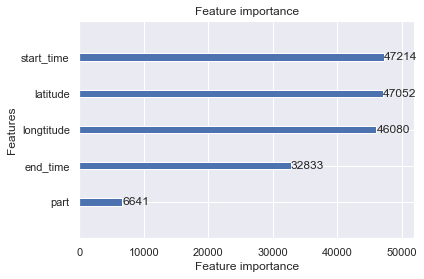

In [57]:
lgb.plot_importance(level_clf)

In [58]:
level_clf.booster_.save_model("level_clf.lgb")

## Train a ranking model

In [41]:
from functools import partial


def featurize(df, test=False):
    df = df.copy()
    split = "train" if not test else "test"

    df["speed_ms"] = df["speed"] / 3.6
    df["flights_string_length"] = df["flights"].swifter.apply(len)
    df.drop(["flights", "speed"], axis=1, inplace=True)

    df["start_date"] = pd.to_datetime(df["start_time"], unit="s")
    df["start_weekday"] = df["start_date"].dt.weekday
    df["start_week_of_year"] = df["start_date"].dt.week
    df["start_hour"] = df["start_date"].dt.hour
    df["start_minute"] = df["start_date"].dt.minute
    df["start_time_epoch"] = df["start_time"].astype("int") // 1e6
    df["start_early_night"] = (df["start_hour"] > 19) | (df["start_hour"] < 3)

    print("* flights features")
    df["hops"] = df.swifter.apply(partial(compute_hops, split=split), axis=1)

    print("** total distance")
    df["target_distance_m"] = df.swifter.apply(compute_target_distance, axis=1)
    df["hypothetical_time_on_foot_s"] = df["target_distance_m"] / df["speed_ms"]

    print("** itinerary distance")
    df["route_distance_m"] = df.swifter.apply(
        partial(compute_route_distance, split=split), axis=1
    )
    df["average_route_distance_m"] = df["route_distance_m"] / df["hops"]
    df["suggested_time_but_on_foot_s"] = df["route_distance_m"] / df["speed_ms"]

    print("** transfer on departure")
    df["transfer_distance_on_departure_m"] = df.progress_apply(
        partial(compute_transfer_distance_on_departure, split=split), axis=1
    )
    df["transfer_time_on_departure_s"] = (
        df["transfer_distance_on_departure_m"] / df["speed_ms"]
    )

    df["prep_time_before_departure_s"] = df.progress_apply(
        partial(compute_prep_time, split=split), axis=1
    )

    print("** transfer on arrival")
    df["transfer_distance_on_arrival_m"] = df.progress_apply(
        partial(compute_transfer_distance_on_arrival, split=split), axis=1
    )
    df["transfer_time_on_arrival_s"] = (
        df["transfer_distance_on_arrival_m"] / df["speed_ms"]
    )

    print("** in-air")
    df["planned_time_in_air_s"] = df.swifter.apply(
        partial(compute_time_in_air, split=split), axis=1
    )
    df["planned_wasted_time_s"] = df.swifter.apply(
        partial(compute_wasted_time, split=split), axis=1
    )
    df["planned_time_in_airports_s"] = (
        df["planned_time_in_air_s"] + df["planned_wasted_time_s"]
    )
    df["planned_time_out_of_airports_s"] = (
        df["prep_time_before_departure_s"] + df["transfer_time_on_arrival_s"]
    )
    df["planned_total_time_by_air_s"] = (
        df["planned_time_in_airports_s"] + df["planned_time_out_of_airports_s"]
    )
    df["total_time_s"] = df.progress_apply(
        partial(compute_total_time, split=split), axis=1
    )

    print("end date features")
    df["planned_end_time"] = df["start_time"] + df["total_time_s"]
    df["planned_end_date"] = pd.to_datetime(df["planned_end_time"], unit="s")
    df["planned_end_weekday"] = df["planned_end_date"].dt.weekday
    df["planned_end_week_of_year"] = df["planned_end_date"].dt.week
    df["planned_end_hour"] = df["planned_end_date"].dt.hour
    df["planned_end_minute"] = df["planned_end_date"].dt.minute
    df["planned_end_time_epoch"] = df["planned_end_time"].astype("int64") // 1e6
    df["planned_end_early_night"] = (df["planned_end_hour"] > 19) | (
        df["planned_end_hour"] < 3
    )

    df["distance_opportunity_cost"] = df["planned_total_time_by_air_s"] * df["speed_ms"]

    categorical = [
        "start_weather_type",
        "start_weather_level",
        "end_weather_type",
        "end_weather_level",
        "hops",
        "query_id",
        "suggestion_id",
        "part_id",
        "start_weekday",
        "start_week_of_year",
        "start_hour",
        "start_minute",
        "start_early_night",
        "planned_end_weekday",
        "planned_end_week_of_year",
        "planned_end_hour",
        "planned_end_minute",
        "planned_end_early_night",
        "cancelled",
    ]
    for col in categorical:
        if col in df:
            df[col] = df.loc[:, col].astype("category")
    df.drop(["start_date", "planned_end_date",], axis=1, inplace=True)
    if not test:
        y = df.loc[:, "relevance"]
        X = df.drop(["relevance"], axis=1)
        return X, y

    return df

In [495]:
X, y = featurize(train_df)

Pandas Apply: 100%|██████████| 227720/227720 [00:00<00:00, 971423.51it/s] 


* flights features


Pandas Apply: 100%|██████████| 227720/227720 [00:04<00:00, 54130.09it/s]


** total distance


Dask Apply: 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


** itinerary distance


Pandas Apply:   0%|          | 0/227720 [00:00<?, ?it/s]

** transfer on departure


Pandas Apply:   0%|          | 0/227720 [00:00<?, ?it/s]

** transfer on arrival


Pandas Apply: 100%|██████████| 227720/227720 [00:03<00:00, 63433.40it/s]


** in-air


Pandas Apply: 100%|██████████| 227720/227720 [00:04<00:00, 51697.67it/s]


end date features


In [496]:
X_test = featurize(test_df, test=True)

Pandas Apply: 100%|██████████| 563640/563640 [00:00<00:00, 1194344.68it/s]


* flights features


Pandas Apply: 100%|██████████| 563640/563640 [00:11<00:00, 51088.20it/s]


** total distance


Dask Apply: 100%|██████████| 32/32 [00:22<00:00,  1.43it/s]


** itinerary distance


Pandas Apply:   0%|          | 0/563640 [00:00<?, ?it/s]

** transfer on departure


Pandas Apply:   0%|          | 0/563640 [00:00<?, ?it/s]

** transfer on arrival


Pandas Apply: 100%|██████████| 563640/563640 [00:10<00:00, 55851.51it/s]


** in-air


Pandas Apply: 100%|██████████| 563640/563640 [00:11<00:00, 48959.66it/s]


end date features


### Simulate weather at the start and end positions

In [44]:
type_clf = lgb.Booster(model_file="type_clf.lgb")
level_clf = lgb.Booster(model_file="level_clf.lgb")

In [45]:
def simulate_weather(df, stage):
    mean_period = (weather["end_time"] - weather["start_time"]).mean()
    if stage == "start":
        start_time = df["start_time"]
        end_time = start_time + mean_period
    else:
        end_time = df["planned_end_time"]
        start_time = end_time - mean_period

    return pd.DataFrame(
        {
            "start_time": start_time.astype("int64"),
            "end_time": end_time.astype("int64"),
            "latitude": df[f"{stage}_lat"].astype("float64"),
            "longtitude": df[f"{stage}_long"].astype("float64"),
            "part": df["part_id"].astype("int8"),
        }
    )

def predict_weather(model, df):
    return np.argmax(model.predict(df), 1)

In [56]:
train_start_weather_sim = simulate_weather(X, "start")
train_end_weather_sim = simulate_weather(X, "end")

test_start_weather_sim = simulate_weather(X_test, "start")
test_end_weather_sim = simulate_weather(X_test, "end")


In [171]:
%%time
predicted_start_type_train = predict_weather(type_clf, train_start_weather_sim)
np.save("predicted_start_type_train", predicted_start_type_train)

CPU times: user 1min 32s, sys: 80.1 ms, total: 1min 32s
Wall time: 1min 32s


In [172]:
%%time
predicted_start_level_train = predict_weather(level_clf, train_start_weather_sim)
np.save("predicted_start_level_train", predicted_start_level_train)

CPU times: user 1min 20s, sys: 76.3 ms, total: 1min 20s
Wall time: 1min 20s


In [173]:
%%time
predicted_end_type_train = predict_weather(type_clf, train_end_weather_sim)
np.save("predicted_end_type_train", predicted_end_type_train)

CPU times: user 1min 49s, sys: 126 ms, total: 1min 49s
Wall time: 1min 49s


In [174]:
%%time
predicted_end_level_train = predict_weather(level_clf, train_end_weather_sim)
np.save("predicted_end_level_train", predicted_end_level_train)

CPU times: user 1min 18s, sys: 71.2 ms, total: 1min 18s
Wall time: 1min 18s


In [58]:
%%time
predicted_start_type_test = predict_weather(type_clf, test_start_weather_sim)
np.save("predicted_start_type_test", predicted_start_type_test)

CPU times: user 4min 6s, sys: 245 ms, total: 4min 6s
Wall time: 4min 6s


In [59]:
%%time
predicted_start_level_test = predict_weather(level_clf, test_start_weather_sim)
np.save("predicted_start_level_test", predicted_start_level_test)

CPU times: user 3min 3s, sys: 128 ms, total: 3min 3s
Wall time: 3min 3s


In [60]:
%%time
predicted_end_type_test = predict_weather(type_clf, test_end_weather_sim)
np.save("predicted_end_type_test", predicted_end_type_test)

CPU times: user 4min 3s, sys: 205 ms, total: 4min 3s
Wall time: 4min 4s


In [61]:
%%time
predicted_end_level_test = predict_weather(level_clf, test_end_weather_sim)
np.save("predicted_end_level_test", predicted_end_level_test)

CPU times: user 3min 25s, sys: 201 ms, total: 3min 25s
Wall time: 3min 25s


In [46]:
predicted_start_type_train = np.load("predicted_start_type_train.npy")
predicted_start_level_train = np.load("predicted_start_level_train.npy")
predicted_end_type_train = np.load("predicted_end_type_train.npy")
predicted_end_level_train = np.load("predicted_end_level_train.npy")
predicted_start_type_test = np.load("predicted_start_type_test.npy")
predicted_start_level_test = np.load("predicted_start_level_test.npy")
predicted_end_type_test = np.load("predicted_end_type_test.npy")
predicted_end_level_test = np.load("predicted_end_level_test.npy")

In [418]:
weather_conditions = {
    "train": {
        "start": {
            "type": predicted_start_type_train,
            "level": predicted_start_level_train,
        },
        "end": {"type": predicted_end_type_train, "level": predicted_end_level_train,},
    },
    "test": {
        "start": {
            "type": predicted_start_type_test,
            "level": predicted_start_level_test,
        },
        "end": {"type": predicted_end_type_test, "level": predicted_end_level_test,},
    },
}

In [419]:
def add_weather_predictions(df, split):
    df["start_weather_type"] = weather_conditions[split]["start"]["type"]
    df["start_weather_level"] = weather_conditions[split]["start"]["level"]
    df["end_weather_type"] = weather_conditions[split]["end"]["type"]
    df["end_weather_level"] = weather_conditions[split]["end"]["level"]
    return df


### Cancellation model

In [37]:
def get_arp_lat(arp_name):
    return arp_coor.get(arp_name, (0, 0))[0]

def get_arp_lon(arp_name):
    return arp_coor.get(arp_name, (0, 0))[1]

In [38]:
def prepare_cancellation_data(df, **kwargs):
    df["departure_lat"] = df["departure_air"].swifter.apply(get_arp_lat)
    df["departure_lon"] = df["departure_air"].swifter.apply(get_arp_lon)
    df["arrival_lat"] = df["arrival_air"].swifter.apply(get_arp_lat)
    df["arrival_lon"] = df["arrival_air"].swifter.apply(get_arp_lon)
    
    categorical = ["departure_air", "arrival_air", "part"]
    for col in categorical:
        df[col] = df.loc[:, col].astype("category")
    return df 

In [45]:
try:
    pd.read_csv("aoa")
except (IOError, ValueError):
    print("1")

1


In [39]:
historical_data = prepare_cancellation_data(
    pd.concat([train_data, test_data]).set_index("flight_id").sample(int(5e5))
)

Pandas Apply: 100%|██████████| 500000/500000 [00:00<00:00, 1032912.40it/s]


In [42]:
historical_data.dtypes

departure_air             category
arrival_air               category
cancelled                     bool
departure_planned_time       int64
arrival_planned_time         int64
departure_actual_time        int64
arrival_actual_time          int64
part                      category
departure_lat              float64
departure_lon              float64
arrival_lat                float64
arrival_lon                float64
dtype: object

In [43]:
historical_data

,departure_air,arrival_air,cancelled,departure_planned_time,arrival_planned_time,departure_actual_time,arrival_actual_time,part,departure_lat,departure_lon,arrival_lat,arrival_lon
flight_id,,,,,,,,,,,,
16771464,DCA,BHM,False,92115800,92123540,92116040,92123420,9,38.852100,-77.037697,33.562901,-86.753502
425031,ATL,FLL,False,11945000,11951900,11945180,11951480,0,33.636700,-84.428101,26.072599,-80.152702
16038250,BNA,BOS,False,87801200,87810380,87800900,87808940,8,36.124500,-86.678200,42.364300,-71.005203
7744327,CLT,MDT,False,49876700,49882160,49876400,49881620,4,35.214001,-80.943100,40.193501,-76.763397
4009524,ATL,HSV,False,30180140,30183560,30179900,30182600,2,33.636700,-84.428101,34.637199,-86.775101
...,...,...,...,...,...,...,...,...,...,...,...,...
9491141,EVV,ORD,False,59048900,59054240,59048900,59053820,6,38.036999,-87.532402,41.978600,-87.904800
15664477,STL,MSP,False,86840600,86846960,86863040,86868080,8,38.748697,-90.370003,44.882000,-93.221802
9424432,PHL,DCA,False,58897400,58901480,58897160,58902800,6,39.871899,-75.241096,38.852100,-77.037697


In [46]:
weather

,start_time,end_time,latitude,longtitude,type,level,part
0,136081340,136087040,42.6973,-73.1696,1,4,6
1,136085120,136087040,39.7719,-94.9097,1,4,6
2,136085480,136087040,39.4944,-121.6222,1,4,6
3,136067960,136087100,35.0147,-80.6242,1,4,6
4,136084640,136087100,48.9318,-95.3405,1,4,6
...,...,...,...,...,...,...,...
982556,26215760,26217920,32.3003,-86.4061,4,1,1
982557,26214260,26217980,41.8065,-107.1952,5,1,1
982558,26214260,26217980,41.7297,-107.7252,5,1,1
982559,26216840,26218040,48.7525,-96.9376,1,2,1


In [41]:
schedule

,departure_air,arrival_air,departure_planned_time,arrival_planned_time,part
flight_id,,,,,
16132315,GUM,HNL,87998600,88110500,8
16132377,GUM,HNL,87998600,88110500,8
16150575,EWR,HNL,88055000,88095740,8
16150578,EWR,HNL,88055000,88095740,8
16151540,JFK,SEA,88056800,88080500,8
...,...,...,...,...,...
25842266,DEN,PHL,137628740,137641400,6
25842269,LAX,DFW,137629700,137640020,6
25842270,LAX,DFW,137629700,137640020,6


In [78]:
def simulate_weather_on_historical_data(df, stage):
    mean_period = (weather["end_time"] - weather["start_time"]).mean()
    if stage == "start":
        start_time = df.loc[:, ["departure_planned_time", "departure_actual_time"]].min(
            axis=1
        )
        end_time = start_time + mean_period
    else:
        end_time = df.loc[:, ["arrival_planned_time", "arrival_actual_time"]].max(
            axis=1
        )
        start_time = end_time - mean_period

    tag = "departure" if stage == "start" else "arrival"
    return pd.DataFrame(
        {
            "start_time": start_time.astype("int64"),
            "end_time": end_time.astype("int64"),
            "latitude": df[f"{tag}_lat"].astype("float64"),
            "longtitude": df[f"{tag}_lon"].astype("float64"),
            "part": df["part"].astype("int8"),
        }
    )

In [61]:
start_weather_sim_on_historical_data = simulate_weather_on_historical_data(historical_data, "start")
end_weather_sim_on_historical_data = simulate_weather_on_historical_data(historical_data, "end")


In [64]:
%%time
predicted_start_type_historical = predict_weather(type_clf, start_weather_sim_on_historical_data)
np.save("predicted_start_type_historical", predicted_start_type_historical)


CPU times: user 4min 39s, sys: 440 ms, total: 4min 39s
Wall time: 4min 39s


In [65]:
%%time
predicted_start_level_historical = predict_weather(level_clf, start_weather_sim_on_historical_data)
np.save("predicted_start_level_historical", predicted_start_level_historical)


CPU times: user 3min 23s, sys: 270 ms, total: 3min 23s
Wall time: 3min 23s


In [66]:
%%time
predicted_end_type_historical = predict_weather(type_clf, end_weather_sim_on_historical_data)
np.save("predicted_end_type_historical", predicted_end_type_historical)


CPU times: user 4min 10s, sys: 285 ms, total: 4min 10s
Wall time: 4min 11s


In [67]:
%%time
predicted_end_level_historical = predict_weather(level_clf, end_weather_sim_on_historical_data)
np.save("predicted_end_level_historical", predicted_end_level_historical)

CPU times: user 3min 13s, sys: 222 ms, total: 3min 14s
Wall time: 3min 14s


In [79]:
predicted_start_type_historical = np.load("predicted_start_type_historical.npy")
predicted_start_level_historical = np.load("predicted_start_level_historical.npy")
predicted_end_type_historical = np.load("predicted_end_type_historical.npy")
predicted_end_level_historical = np.load("predicted_end_level_historical.npy")

In [80]:
historical_data["start_type"] = predicted_start_type_historical
historical_data["start_type"] = historical_data["start_type"].astype("category")

historical_data["end_type"] = predicted_end_type_historical
historical_data["end_type"] = historical_data["end_type"].astype("category")

historical_data["start_level"] = predicted_start_level_historical
historical_data["start_level"] = historical_data["start_level"].astype("category")

historical_data["end_level"] = predicted_end_level_historical
historical_data["end_level"] = historical_data["end_level"].astype("category")

In [81]:
historical_data

,departure_air,arrival_air,cancelled,departure_planned_time,arrival_planned_time,departure_actual_time,arrival_actual_time,part,departure_lat,departure_lon,arrival_lat,arrival_lon,start_type,end_type,start_level,end_level
flight_id,,,,,,,,,,,,,,,,
9518672,SNA,DFW,False,59115500,59126780,59115380,59125820,6,33.675701,-117.867996,32.896801,-97.038002,1,1,4,4
22913450,SMF,ORD,False,116573000,116587400,116572640,116586620,0,38.695400,-121.591003,41.978600,-87.904800,1,1,2,2
260693,IAH,LAS,False,11456600,11468240,11456660,11467700,0,29.984400,-95.341400,36.080101,-115.152000,1,4,2,1
10453868,MYR,PIT,False,63539900,63545180,63539540,63544160,7,33.679699,-78.928299,40.491501,-80.232903,1,1,2,2
9579156,ORD,DEN,False,59230100,59240000,59229680,59238020,6,41.978600,-87.904800,39.861698,-104.672996,4,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9239934,OAK,BUR,False,58509200,58513400,58509080,58513400,6,37.721298,-122.221001,34.200699,-118.359001,4,4,2,1
7698926,IAH,MFE,False,49744100,49748840,49743560,49747520,4,29.984400,-95.341400,26.175800,-98.238602,5,1,1,2
16079079,IAH,SMF,False,87890600,87906140,87890540,87906260,8,29.984400,-95.341400,38.695400,-121.591003,4,1,1,2


In [82]:
X_cancellation =  historical_data.drop(
        ["cancelled", "departure_actual_time", "arrival_actual_time"], axis=1
)
y_cancellation = historical_data["cancelled"]

In [82]:
msk = np.random.rand(len(X_cancellation)) < 0.8

X_cancellation_train, y_cancellation_train = (
    X_cancellation.loc[msk],
    y_cancellation.loc[msk],
)
X_cancellation_val, y_cancellation_val = (
    X_cancellation.loc[~msk],
    y_cancellation.loc[~msk],
)

In [87]:
cancellation_clf = lgb.LGBMClassifier(n_estimators=1000, reg_lambda=1.0, colsample_bytree=0.8, max_depth=20)
cancellation_clf.fit(
    X_cancellation_train,
    y_cancellation_train,
    eval_set=[(X_cancellation_val, y_cancellation_val)],
    early_stopping_rounds=100,
    eval_metric=["auc", "logloss"],
)


[1]	valid_0's auc: 0.843494	valid_0's binary_logloss: 0.0883634
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.886431	valid_0's binary_logloss: 0.0823165
[3]	valid_0's auc: 0.893389	valid_0's binary_logloss: 0.0780917
[4]	valid_0's auc: 0.895367	valid_0's binary_logloss: 0.0754855
[5]	valid_0's auc: 0.901712	valid_0's binary_logloss: 0.0730454
[6]	valid_0's auc: 0.904663	valid_0's binary_logloss: 0.0714997
[7]	valid_0's auc: 0.916778	valid_0's binary_logloss: 0.0693813
[8]	valid_0's auc: 0.921162	valid_0's binary_logloss: 0.0679962
[9]	valid_0's auc: 0.92488	valid_0's binary_logloss: 0.0666994
[10]	valid_0's auc: 0.927765	valid_0's binary_logloss: 0.0654202
[11]	valid_0's auc: 0.930024	valid_0's binary_logloss: 0.06431
[12]	valid_0's auc: 0.930849	valid_0's binary_logloss: 0.0632275
[13]	valid_0's auc: 0.932834	valid_0's binary_logloss: 0.0622631
[14]	valid_0's auc: 0.933849	valid_0's binary_logloss: 0.0614654
[15]	valid_0's auc: 0.934298	valid_0's b

[128]	valid_0's auc: 0.965456	valid_0's binary_logloss: 0.0436601
[129]	valid_0's auc: 0.96552	valid_0's binary_logloss: 0.0436243
[130]	valid_0's auc: 0.965495	valid_0's binary_logloss: 0.0436149
[131]	valid_0's auc: 0.965853	valid_0's binary_logloss: 0.0434543
[132]	valid_0's auc: 0.965821	valid_0's binary_logloss: 0.04344
[133]	valid_0's auc: 0.965855	valid_0's binary_logloss: 0.0434142
[134]	valid_0's auc: 0.965946	valid_0's binary_logloss: 0.0433552
[135]	valid_0's auc: 0.965895	valid_0's binary_logloss: 0.0433613
[136]	valid_0's auc: 0.965905	valid_0's binary_logloss: 0.0433432
[137]	valid_0's auc: 0.965926	valid_0's binary_logloss: 0.043335
[138]	valid_0's auc: 0.966039	valid_0's binary_logloss: 0.0432481
[139]	valid_0's auc: 0.96621	valid_0's binary_logloss: 0.0431768
[140]	valid_0's auc: 0.966214	valid_0's binary_logloss: 0.0431607
[141]	valid_0's auc: 0.96636	valid_0's binary_logloss: 0.0430948
[142]	valid_0's auc: 0.966302	valid_0's binary_logloss: 0.0430954
[143]	valid_0's 

[257]	valid_0's auc: 0.969463	valid_0's binary_logloss: 0.0410909
[258]	valid_0's auc: 0.969491	valid_0's binary_logloss: 0.041084
[259]	valid_0's auc: 0.969451	valid_0's binary_logloss: 0.0410874
[260]	valid_0's auc: 0.969456	valid_0's binary_logloss: 0.0410855
[261]	valid_0's auc: 0.969484	valid_0's binary_logloss: 0.0410715
[262]	valid_0's auc: 0.969494	valid_0's binary_logloss: 0.0410685
[263]	valid_0's auc: 0.969529	valid_0's binary_logloss: 0.0410586
[264]	valid_0's auc: 0.969513	valid_0's binary_logloss: 0.0410605
[265]	valid_0's auc: 0.96964	valid_0's binary_logloss: 0.0410237
[266]	valid_0's auc: 0.969896	valid_0's binary_logloss: 0.0409071
[267]	valid_0's auc: 0.969946	valid_0's binary_logloss: 0.040893
[268]	valid_0's auc: 0.969946	valid_0's binary_logloss: 0.0408932
[269]	valid_0's auc: 0.969945	valid_0's binary_logloss: 0.0408854
[270]	valid_0's auc: 0.970002	valid_0's binary_logloss: 0.0408636
[271]	valid_0's auc: 0.969988	valid_0's binary_logloss: 0.0408504
[272]	valid_0

[382]	valid_0's auc: 0.971045	valid_0's binary_logloss: 0.0400511
[383]	valid_0's auc: 0.971038	valid_0's binary_logloss: 0.0400539
[384]	valid_0's auc: 0.971036	valid_0's binary_logloss: 0.0400575
[385]	valid_0's auc: 0.971038	valid_0's binary_logloss: 0.040047
[386]	valid_0's auc: 0.971009	valid_0's binary_logloss: 0.0400496
[387]	valid_0's auc: 0.970982	valid_0's binary_logloss: 0.040061
[388]	valid_0's auc: 0.970994	valid_0's binary_logloss: 0.0400536
[389]	valid_0's auc: 0.971027	valid_0's binary_logloss: 0.0400448
[390]	valid_0's auc: 0.971019	valid_0's binary_logloss: 0.0400488
[391]	valid_0's auc: 0.971027	valid_0's binary_logloss: 0.0400516
[392]	valid_0's auc: 0.97099	valid_0's binary_logloss: 0.0400551
[393]	valid_0's auc: 0.970968	valid_0's binary_logloss: 0.0400598
[394]	valid_0's auc: 0.970975	valid_0's binary_logloss: 0.0400582
[395]	valid_0's auc: 0.970962	valid_0's binary_logloss: 0.0400741
[396]	valid_0's auc: 0.970957	valid_0's binary_logloss: 0.0400824
[397]	valid_0

[512]	valid_0's auc: 0.971309	valid_0's binary_logloss: 0.0398826
[513]	valid_0's auc: 0.971265	valid_0's binary_logloss: 0.039897
[514]	valid_0's auc: 0.971212	valid_0's binary_logloss: 0.0399111
[515]	valid_0's auc: 0.971185	valid_0's binary_logloss: 0.0399174
[516]	valid_0's auc: 0.971172	valid_0's binary_logloss: 0.0399196
[517]	valid_0's auc: 0.971108	valid_0's binary_logloss: 0.0399359
[518]	valid_0's auc: 0.971096	valid_0's binary_logloss: 0.0399301
[519]	valid_0's auc: 0.971092	valid_0's binary_logloss: 0.0399336
[520]	valid_0's auc: 0.971067	valid_0's binary_logloss: 0.0399361
[521]	valid_0's auc: 0.971033	valid_0's binary_logloss: 0.0399453
[522]	valid_0's auc: 0.971024	valid_0's binary_logloss: 0.0399461
[523]	valid_0's auc: 0.970954	valid_0's binary_logloss: 0.0399613
[524]	valid_0's auc: 0.97096	valid_0's binary_logloss: 0.0399596
[525]	valid_0's auc: 0.970948	valid_0's binary_logloss: 0.0399566
[526]	valid_0's auc: 0.970946	valid_0's binary_logloss: 0.0399575
[527]	valid_

LGBMClassifier(colsample_bytree=0.8, max_depth=20, n_estimators=1000,
               reg_lambda=1.0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

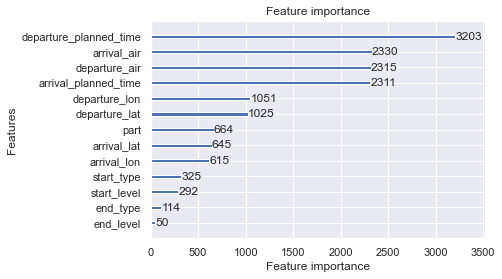

In [88]:
lgb.plot_importance(cancellation_clf)

In [89]:
cancellation_clf.booster_.save_model("cancellation_clf.lgb")


In [85]:
cancellation_clf = lgb.Booster(model_file="cancellation_clf.lgb")

In [92]:
def simulate_weather_on_schedule(df, stage):
    mean_period = (weather["end_time"] - weather["start_time"]).mean()
    if stage == "start":
        start_time = df.loc[:, "departure_planned_time"]
        end_time = start_time + mean_period
    else:
        end_time = df.loc[:, "arrival_planned_time"]
        start_time = end_time - mean_period

    tag = "departure" if stage == "start" else "arrival"
    return pd.DataFrame(
        {
            "start_time": start_time.astype("int64"),
            "end_time": end_time.astype("int64"),
            "latitude": df[f"{tag}_lat"].astype("float64"),
            "longtitude": df[f"{tag}_lon"].astype("float64"),
            "part": df["part"].astype("int8"),
        }
    )


In [94]:
prepared_schedule = prepare_cancellation_data(schedule)
start_weather_sim_on_schedule_data = simulate_weather_on_schedule(prepared_schedule, "start")
end_weather_sim_on_schedule_data = simulate_weather_on_schedule(prepared_schedule, "end")


Pandas Apply: 100%|██████████| 1028241/1028241 [00:00<00:00, 1167368.18it/s]


In [95]:
prepared_schedule.dtypes

departure_air             category
arrival_air               category
departure_planned_time       int64
arrival_planned_time         int64
part                      category
departure_lat              float64
departure_lon              float64
arrival_lat                float64
arrival_lon                float64
dtype: object

In [60]:
%%time
predicted_start_type_schedule = predict_weather(type_clf, start_weather_sim_on_schedule_data)
np.save("predicted_start_type_schedule", predicted_start_type_schedule)


CPU times: user 9min, sys: 519 ms, total: 9min 1s
Wall time: 9min 1s


In [61]:
%%time
predicted_start_level_schedule = predict_weather(level_clf, start_weather_sim_on_schedule_data)
np.save("predicted_start_level_schedule", predicted_start_level_schedule)


CPU times: user 6min 28s, sys: 269 ms, total: 6min 28s
Wall time: 6min 28s


In [62]:
%%time
predicted_end_type_schedule = predict_weather(type_clf, end_weather_sim_on_schedule_data)
np.save("predicted_end_type_schedule", predicted_end_type_schedule)


CPU times: user 8min 58s, sys: 537 ms, total: 8min 59s
Wall time: 8min 59s


In [63]:
%%time
predicted_end_level_schedule = predict_weather(level_clf, end_weather_sim_on_schedule_data)
np.save("predicted_end_level_schedule", predicted_end_level_schedule)

CPU times: user 5min 32s, sys: 227 ms, total: 5min 32s
Wall time: 5min 33s


In [96]:
predicted_start_type_schedule = np.load("predicted_start_type_schedule.npy")
predicted_start_level_schedule = np.load("predicted_start_level_schedule.npy")
predicted_end_type_schedule = np.load("predicted_end_type_schedule.npy")
predicted_end_level_schedule = np.load("predicted_end_level_schedule.npy")


In [97]:
prepared_schedule["start_type"] = predicted_start_type_schedule
prepared_schedule["start_type"] = schedule["start_type"].astype("category")

prepared_schedule["end_type"] = predicted_end_type_schedule
prepared_schedule["end_type"] = schedule["end_type"].astype("category")

prepared_schedule["start_level"] = predicted_start_level_schedule
prepared_schedule["start_level"] = schedule["start_level"].astype("category")

prepared_schedule["end_level"] = predicted_end_level_schedule
prepared_schedule["end_level"] = schedule["end_level"].astype("category")

In [98]:
X_cancellation.dtypes

departure_air             category
arrival_air               category
departure_planned_time       int64
arrival_planned_time         int64
part                      category
departure_lat              float64
departure_lon              float64
arrival_lat                float64
arrival_lon                float64
start_type                category
end_type                  category
start_level               category
end_level                 category
dtype: object

In [99]:
prepared_schedule.iloc[:10].dtypes

departure_air             category
arrival_air               category
departure_planned_time       int64
arrival_planned_time         int64
part                      category
departure_lat              float64
departure_lon              float64
arrival_lat                float64
arrival_lon                float64
start_type                category
end_type                  category
start_level               category
end_level                 category
dtype: object

In [101]:
schedule_cancelled = cancellation_clf.predict(prepared_schedule)

In [107]:
np.save("schedule_cancelled", schedule_cancelled)

In [108]:
prepared_schedule["not_cancelled"] = 1 - schedule_cancelled

In [112]:
@persist_to_file("not_cancelled_proba_by_id")
def get_not_cancelled_proba_by_id():
    return prepared_schedule.not_cancelled.to_dict()

not_cancelled_proba_by_id = get_not_cancelled_proba_by_id()

In [394]:
def compute_not_cancelled(row, split):
    key = get_key(row) 

    proba = 1
    flights = suggested_itinerary_by_split[split][key]
    if not flights:
        return proba


    for flight_id in flights:
        proba *= not_cancelled_proba_by_id.get(str(flight_id), 1)
        
    return proba
    

In [399]:
def add_cancellation_data(df,split):
    df["not_cancelled"] = df.progress_apply(partial(compute_not_cancelled, split=split), axis=1)
    df["cancelled"] = df["not_cancelled"] < 0.5
    return df


## Training a regression model to predict delays

In [209]:
historical_data.dtypes

departure_air             category
arrival_air               category
cancelled                     bool
departure_planned_time       int64
arrival_planned_time         int64
departure_actual_time        int64
arrival_actual_time          int64
part                      category
departure_lat              float64
departure_lon              float64
arrival_lat                float64
arrival_lon                float64
start_type                category
end_type                  category
start_level               category
end_level                 category
dtype: object

In [210]:
X_delay = historical_data.drop(["departure_actual_time", "arrival_actual_time"], axis=1)

delay_departure = (historical_data["departure_actual_time"] - historical_data["departure_planned_time"]) / historical_data["departure_planned_time"]
delay_departure = (delay_departure - delay_departure.mean()) / delay_departure.std()

delay_arrival = (historical_data["arrival_actual_time"] - historical_data["arrival_planned_time"])/ historical_data["arrival_planned_time"] 
delay_arrival = (delay_arrival - delay_arrival.mean()) / delay_arrival.std()


In [211]:
delay_departure

flight_id
9518672     0.149508
22913450    0.149501
260693      0.149558
10453868    0.149484
9579156     0.149474
              ...   
9239934     0.149508
7698926     0.149448
16079079    0.149518
4729579     0.149570
3363072     0.149411
Length: 500000, dtype: float64

In [212]:
msk = np.random.rand(len(X_delay)) < 0.8

X_delay_train, y_departure_delay_train, y_arrival_delay_train = (
    X_delay.loc[msk],
    delay_departure.loc[msk],
    delay_arrival.loc[msk],
)

X_delay_val, y_departure_delay_val, y_arrival_delay_val = (
    X_delay.loc[~msk],
    delay_departure.loc[~msk],
    delay_arrival.loc[~msk],
)

In [213]:
%%time
delay_departure_reg = lgb.LGBMRegressor(
    n_estimators=1000, 
    reg_lambda=1.0,
    colsample_bytree=0.8, 
    max_depth=5,
    num_leaves=3
)
delay_departure_reg.fit(
    X_delay_train,
    y_departure_delay_train,
    eval_set=[(X_delay_val, y_departure_delay_val)],
    early_stopping_rounds=1000,
    eval_metric=["l1", "l2"],
)


[1]	valid_0's l1: 0.289181	valid_0's l2: 0.97617
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l1: 0.260281	valid_0's l2: 0.790945
[3]	valid_0's l1: 0.23427	valid_0's l2: 0.6409
[4]	valid_0's l1: 0.21086	valid_0's l2: 0.519351
[5]	valid_0's l1: 0.207988	valid_0's l2: 0.507057
[6]	valid_0's l1: 0.187207	valid_0's l2: 0.411204
[7]	valid_0's l1: 0.168503	valid_0's l2: 0.333555
[8]	valid_0's l1: 0.151668	valid_0's l2: 0.270663
[9]	valid_0's l1: 0.136518	valid_0's l2: 0.219697
[10]	valid_0's l1: 0.134965	valid_0's l2: 0.216108
[11]	valid_0's l1: 0.121486	valid_0's l2: 0.175719
[12]	valid_0's l1: 0.109354	valid_0's l2: 0.143013
[13]	valid_0's l1: 0.108322	valid_0's l2: 0.141433
[14]	valid_0's l1: 0.0975074	valid_0's l2: 0.115383
[15]	valid_0's l1: 0.0877744	valid_0's l2: 0.0942792
[16]	valid_0's l1: 0.0790193	valid_0's l2: 0.0771592
[17]	valid_0's l1: 0.0711386	valid_0's l2: 0.0632848
[18]	valid_0's l1: 0.071028	valid_0's l2: 0.0631916
[19]	valid_0's l1: 0.0639

[160]	valid_0's l1: 0.00542726	valid_0's l2: 0.000311433
[161]	valid_0's l1: 0.00530806	valid_0's l2: 0.00030067
[162]	valid_0's l1: 0.00528755	valid_0's l2: 0.000299065
[163]	valid_0's l1: 0.00520022	valid_0's l2: 0.000296485
[164]	valid_0's l1: 0.00507636	valid_0's l2: 0.000294297
[165]	valid_0's l1: 0.00505341	valid_0's l2: 0.000284672
[166]	valid_0's l1: 0.00503499	valid_0's l2: 0.000282758
[167]	valid_0's l1: 0.00501521	valid_0's l2: 0.000281215
[168]	valid_0's l1: 0.0049811	valid_0's l2: 0.000272148
[169]	valid_0's l1: 0.00496147	valid_0's l2: 0.00027058
[170]	valid_0's l1: 0.0049454	valid_0's l2: 0.000269123
[171]	valid_0's l1: 0.00492408	valid_0's l2: 0.000261085
[172]	valid_0's l1: 0.00490542	valid_0's l2: 0.000259635
[173]	valid_0's l1: 0.00479242	valid_0's l2: 0.000257892
[174]	valid_0's l1: 0.00474655	valid_0's l2: 0.000251099
[175]	valid_0's l1: 0.00473143	valid_0's l2: 0.000249677
[176]	valid_0's l1: 0.00467515	valid_0's l2: 0.000245754
[177]	valid_0's l1: 0.00466319	vali

[320]	valid_0's l1: 0.00223735	valid_0's l2: 8.88229e-05
[321]	valid_0's l1: 0.00219449	valid_0's l2: 8.77153e-05
[322]	valid_0's l1: 0.00219301	valid_0's l2: 8.74887e-05
[323]	valid_0's l1: 0.00218954	valid_0's l2: 8.73109e-05
[324]	valid_0's l1: 0.00218656	valid_0's l2: 8.71253e-05
[325]	valid_0's l1: 0.0021898	valid_0's l2: 8.53648e-05
[326]	valid_0's l1: 0.00218468	valid_0's l2: 8.53391e-05
[327]	valid_0's l1: 0.00217808	valid_0's l2: 8.52008e-05
[328]	valid_0's l1: 0.00216312	valid_0's l2: 8.51512e-05
[329]	valid_0's l1: 0.00215902	valid_0's l2: 8.51218e-05
[330]	valid_0's l1: 0.00216113	valid_0's l2: 8.35826e-05
[331]	valid_0's l1: 0.0021575	valid_0's l2: 8.35648e-05
[332]	valid_0's l1: 0.00215943	valid_0's l2: 8.2307e-05
[333]	valid_0's l1: 0.00214191	valid_0's l2: 8.07287e-05
[334]	valid_0's l1: 0.00212515	valid_0's l2: 7.93181e-05
[335]	valid_0's l1: 0.00212189	valid_0's l2: 7.91717e-05
[336]	valid_0's l1: 0.00211367	valid_0's l2: 7.91276e-05
[337]	valid_0's l1: 0.0020961	vali

[476]	valid_0's l1: 0.00128145	valid_0's l2: 2.72132e-05
[477]	valid_0's l1: 0.00127959	valid_0's l2: 2.72034e-05
[478]	valid_0's l1: 0.00127704	valid_0's l2: 2.71482e-05
[479]	valid_0's l1: 0.00127858	valid_0's l2: 2.68103e-05
[480]	valid_0's l1: 0.00127143	valid_0's l2: 2.67682e-05
[481]	valid_0's l1: 0.00127104	valid_0's l2: 2.67629e-05
[482]	valid_0's l1: 0.00126839	valid_0's l2: 2.67576e-05
[483]	valid_0's l1: 0.00126016	valid_0's l2: 2.64443e-05
[484]	valid_0's l1: 0.00125276	valid_0's l2: 2.61914e-05
[485]	valid_0's l1: 0.00124942	valid_0's l2: 2.61371e-05
[486]	valid_0's l1: 0.00125149	valid_0's l2: 2.57465e-05
[487]	valid_0's l1: 0.00124426	valid_0's l2: 2.54979e-05
[488]	valid_0's l1: 0.00124624	valid_0's l2: 2.51598e-05
[489]	valid_0's l1: 0.00123921	valid_0's l2: 2.49215e-05
[490]	valid_0's l1: 0.00124131	valid_0's l2: 2.45777e-05
[491]	valid_0's l1: 0.00123454	valid_0's l2: 2.45452e-05
[492]	valid_0's l1: 0.00122763	valid_0's l2: 2.43144e-05
[493]	valid_0's l1: 0.00122985	

[631]	valid_0's l1: 0.000858845	valid_0's l2: 1.22013e-05
[632]	valid_0's l1: 0.000855407	valid_0's l2: 1.21808e-05
[633]	valid_0's l1: 0.000857332	valid_0's l2: 1.20208e-05
[634]	valid_0's l1: 0.00085256	valid_0's l2: 1.19563e-05
[635]	valid_0's l1: 0.000848803	valid_0's l2: 1.19032e-05
[636]	valid_0's l1: 0.000845076	valid_0's l2: 1.14004e-05
[637]	valid_0's l1: 0.000847785	valid_0's l2: 1.13605e-05
[638]	valid_0's l1: 0.000845059	valid_0's l2: 1.13043e-05
[639]	valid_0's l1: 0.000847712	valid_0's l2: 1.12644e-05
[640]	valid_0's l1: 0.000845899	valid_0's l2: 1.12113e-05
[641]	valid_0's l1: 0.000848559	valid_0's l2: 1.11716e-05
[642]	valid_0's l1: 0.000846782	valid_0's l2: 1.11214e-05
[643]	valid_0's l1: 0.000849472	valid_0's l2: 1.10821e-05
[644]	valid_0's l1: 0.000847072	valid_0's l2: 1.10719e-05
[645]	valid_0's l1: 0.000842531	valid_0's l2: 1.10264e-05
[646]	valid_0's l1: 0.000841064	valid_0's l2: 1.09816e-05
[647]	valid_0's l1: 0.000843791	valid_0's l2: 1.09398e-05
[648]	valid_0's

[787]	valid_0's l1: 0.000665019	valid_0's l2: 6.40616e-06
[788]	valid_0's l1: 0.000662397	valid_0's l2: 6.40208e-06
[789]	valid_0's l1: 0.00066203	valid_0's l2: 6.40151e-06
[790]	valid_0's l1: 0.000663202	valid_0's l2: 6.39392e-06
[791]	valid_0's l1: 0.000660493	valid_0's l2: 6.38729e-06
[792]	valid_0's l1: 0.000662901	valid_0's l2: 6.37609e-06
[793]	valid_0's l1: 0.000660172	valid_0's l2: 6.36937e-06
[794]	valid_0's l1: 0.000661326	valid_0's l2: 6.36335e-06
[795]	valid_0's l1: 0.000658864	valid_0's l2: 6.35795e-06
[796]	valid_0's l1: 0.00065845	valid_0's l2: 6.35019e-06
[797]	valid_0's l1: 0.000654705	valid_0's l2: 6.32499e-06
[798]	valid_0's l1: 0.000652986	valid_0's l2: 6.2139e-06
[799]	valid_0's l1: 0.000654181	valid_0's l2: 6.20708e-06
[800]	valid_0's l1: 0.000650423	valid_0's l2: 6.18597e-06
[801]	valid_0's l1: 0.000652971	valid_0's l2: 6.17424e-06
[802]	valid_0's l1: 0.000655272	valid_0's l2: 6.16455e-06
[803]	valid_0's l1: 0.000651869	valid_0's l2: 6.14744e-06
[804]	valid_0's l

[940]	valid_0's l1: 0.000552861	valid_0's l2: 4.68183e-06
[941]	valid_0's l1: 0.00055297	valid_0's l2: 4.68109e-06
[942]	valid_0's l1: 0.000551456	valid_0's l2: 4.67869e-06
[943]	valid_0's l1: 0.000550254	valid_0's l2: 4.67158e-06
[944]	valid_0's l1: 0.000550299	valid_0's l2: 4.67143e-06
[945]	valid_0's l1: 0.000550213	valid_0's l2: 4.67114e-06
[946]	valid_0's l1: 0.000549823	valid_0's l2: 4.6695e-06
[947]	valid_0's l1: 0.000549467	valid_0's l2: 4.66922e-06
[948]	valid_0's l1: 0.000549583	valid_0's l2: 4.6686e-06
[949]	valid_0's l1: 0.000548586	valid_0's l2: 4.66797e-06
[950]	valid_0's l1: 0.000548619	valid_0's l2: 4.66793e-06
[951]	valid_0's l1: 0.000547473	valid_0's l2: 4.66178e-06
[952]	valid_0's l1: 0.000547484	valid_0's l2: 4.66152e-06
[953]	valid_0's l1: 0.000545946	valid_0's l2: 4.65576e-06
[954]	valid_0's l1: 0.000546068	valid_0's l2: 4.65525e-06
[955]	valid_0's l1: 0.000545877	valid_0's l2: 4.65516e-06
[956]	valid_0's l1: 0.000545932	valid_0's l2: 4.65487e-06
[957]	valid_0's l

LGBMRegressor(colsample_bytree=0.8, max_depth=5, n_estimators=1000,
              num_leaves=3, reg_lambda=1.0)

In [214]:
%%time
delay_arrival_reg = lgb.LGBMRegressor(
    n_estimators=1000, 
    reg_lambda=1.0,
    colsample_bytree=0.8, 
    max_depth=5,
    num_leaves=3
)
delay_arrival_reg.fit(
    X_delay_train,
    y_arrival_delay_train,
    eval_set=[(X_delay_val, y_arrival_delay_val)],
    early_stopping_rounds=1000,
    eval_metric=["l1", "l2"],
)



[1]	valid_0's l1: 0.289182	valid_0's l2: 0.97617
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l1: 0.260281	valid_0's l2: 0.790946
[3]	valid_0's l1: 0.23427	valid_0's l2: 0.6409
[4]	valid_0's l1: 0.21086	valid_0's l2: 0.519351
[5]	valid_0's l1: 0.207988	valid_0's l2: 0.507057
[6]	valid_0's l1: 0.187207	valid_0's l2: 0.411204
[7]	valid_0's l1: 0.168503	valid_0's l2: 0.333556
[8]	valid_0's l1: 0.151668	valid_0's l2: 0.270663
[9]	valid_0's l1: 0.136518	valid_0's l2: 0.219698
[10]	valid_0's l1: 0.134965	valid_0's l2: 0.216108
[11]	valid_0's l1: 0.121487	valid_0's l2: 0.175719
[12]	valid_0's l1: 0.109354	valid_0's l2: 0.143014
[13]	valid_0's l1: 0.108322	valid_0's l2: 0.141433
[14]	valid_0's l1: 0.0975075	valid_0's l2: 0.115383
[15]	valid_0's l1: 0.0877744	valid_0's l2: 0.0942796
[16]	valid_0's l1: 0.0790193	valid_0's l2: 0.0771595
[17]	valid_0's l1: 0.0711387	valid_0's l2: 0.0632851
[18]	valid_0's l1: 0.0710282	valid_0's l2: 0.063192
[19]	valid_0's l1: 0.0639

[165]	valid_0's l1: 0.00504924	valid_0's l2: 0.000290166
[166]	valid_0's l1: 0.00502427	valid_0's l2: 0.000280567
[167]	valid_0's l1: 0.00500701	valid_0's l2: 0.000278817
[168]	valid_0's l1: 0.00497327	valid_0's l2: 0.000270161
[169]	valid_0's l1: 0.00495305	valid_0's l2: 0.000268412
[170]	valid_0's l1: 0.00493742	valid_0's l2: 0.000266882
[171]	valid_0's l1: 0.00491578	valid_0's l2: 0.000259228
[172]	valid_0's l1: 0.00489622	valid_0's l2: 0.000257638
[173]	valid_0's l1: 0.00479082	valid_0's l2: 0.000249835
[174]	valid_0's l1: 0.00467896	valid_0's l2: 0.000248111
[175]	valid_0's l1: 0.00466115	valid_0's l2: 0.000246706
[176]	valid_0's l1: 0.00465042	valid_0's l2: 0.000245471
[177]	valid_0's l1: 0.00462808	valid_0's l2: 0.000238684
[178]	valid_0's l1: 0.00452665	valid_0's l2: 0.000237286
[179]	valid_0's l1: 0.0045162	valid_0's l2: 0.000235998
[180]	valid_0's l1: 0.00448979	valid_0's l2: 0.000230011
[181]	valid_0's l1: 0.00447165	valid_0's l2: 0.000228625
[182]	valid_0's l1: 0.00446117	v

[329]	valid_0's l1: 0.00212534	valid_0's l2: 7.25652e-05
[330]	valid_0's l1: 0.00212967	valid_0's l2: 7.11805e-05
[331]	valid_0's l1: 0.00212127	valid_0's l2: 7.11448e-05
[332]	valid_0's l1: 0.00211484	valid_0's l2: 7.11186e-05
[333]	valid_0's l1: 0.00210304	valid_0's l2: 7.01544e-05
[334]	valid_0's l1: 0.00210717	valid_0's l2: 6.88547e-05
[335]	valid_0's l1: 0.00209196	valid_0's l2: 6.87007e-05
[336]	valid_0's l1: 0.00208585	valid_0's l2: 6.76081e-05
[337]	valid_0's l1: 0.00207566	valid_0's l2: 6.7581e-05
[338]	valid_0's l1: 0.00207464	valid_0's l2: 6.73779e-05
[339]	valid_0's l1: 0.00206341	valid_0's l2: 6.73357e-05
[340]	valid_0's l1: 0.00203257	valid_0's l2: 6.65792e-05
[341]	valid_0's l1: 0.00203195	valid_0's l2: 6.63828e-05
[342]	valid_0's l1: 0.0020291	valid_0's l2: 6.62316e-05
[343]	valid_0's l1: 0.00202829	valid_0's l2: 6.60575e-05
[344]	valid_0's l1: 0.00202863	valid_0's l2: 6.60333e-05
[345]	valid_0's l1: 0.0020146	valid_0's l2: 6.5983e-05
[346]	valid_0's l1: 0.00200772	vali

[481]	valid_0's l1: 0.00126459	valid_0's l2: 2.30353e-05
[482]	valid_0's l1: 0.00126313	valid_0's l2: 2.29687e-05
[483]	valid_0's l1: 0.00125882	valid_0's l2: 2.29486e-05
[484]	valid_0's l1: 0.00125792	valid_0's l2: 2.28698e-05
[485]	valid_0's l1: 0.00125869	valid_0's l2: 2.28555e-05
[486]	valid_0's l1: 0.0012546	valid_0's l2: 2.28401e-05
[487]	valid_0's l1: 0.00125368	valid_0's l2: 2.28313e-05
[488]	valid_0's l1: 0.00124128	valid_0's l2: 2.2665e-05
[489]	valid_0's l1: 0.00124048	valid_0's l2: 2.25779e-05
[490]	valid_0's l1: 0.00122789	valid_0's l2: 2.24394e-05
[491]	valid_0's l1: 0.00122702	valid_0's l2: 2.23588e-05
[492]	valid_0's l1: 0.0012255	valid_0's l2: 2.22941e-05
[493]	valid_0's l1: 0.00122175	valid_0's l2: 2.22811e-05
[494]	valid_0's l1: 0.00122333	valid_0's l2: 2.19703e-05
[495]	valid_0's l1: 0.00122448	valid_0's l2: 2.1688e-05
[496]	valid_0's l1: 0.00121791	valid_0's l2: 2.16512e-05
[497]	valid_0's l1: 0.00121129	valid_0's l2: 2.14401e-05
[498]	valid_0's l1: 0.0012095	valid

[639]	valid_0's l1: 0.000877896	valid_0's l2: 1.07947e-05
[640]	valid_0's l1: 0.000872355	valid_0's l2: 1.07375e-05
[641]	valid_0's l1: 0.00087261	valid_0's l2: 1.07044e-05
[642]	valid_0's l1: 0.000869693	valid_0's l2: 1.06793e-05
[643]	valid_0's l1: 0.000868235	valid_0's l2: 1.06505e-05
[644]	valid_0's l1: 0.000866811	valid_0's l2: 1.06192e-05
[645]	valid_0's l1: 0.000861665	valid_0's l2: 1.05686e-05
[646]	valid_0's l1: 0.000857897	valid_0's l2: 1.01703e-05
[647]	valid_0's l1: 0.000859808	valid_0's l2: 1.01401e-05
[648]	valid_0's l1: 0.000861558	valid_0's l2: 1.01155e-05
[649]	valid_0's l1: 0.000856226	valid_0's l2: 1.00624e-05
[650]	valid_0's l1: 0.000854211	valid_0's l2: 1.00423e-05
[651]	valid_0's l1: 0.000856026	valid_0's l2: 1.002e-05
[652]	valid_0's l1: 0.000856103	valid_0's l2: 1.00129e-05
[653]	valid_0's l1: 0.000854093	valid_0's l2: 1.00103e-05
[654]	valid_0's l1: 0.000853455	valid_0's l2: 9.99908e-06
[655]	valid_0's l1: 0.000848125	valid_0's l2: 9.94677e-06
[656]	valid_0's l

[789]	valid_0's l1: 0.000683035	valid_0's l2: 6.42145e-06
[790]	valid_0's l1: 0.000684308	valid_0's l2: 6.41259e-06
[791]	valid_0's l1: 0.000682208	valid_0's l2: 6.40447e-06
[792]	valid_0's l1: 0.000681692	valid_0's l2: 6.39091e-06
[793]	valid_0's l1: 0.000680361	valid_0's l2: 6.38919e-06
[794]	valid_0's l1: 0.000679356	valid_0's l2: 6.38779e-06
[795]	valid_0's l1: 0.00067908	valid_0's l2: 6.38709e-06
[796]	valid_0's l1: 0.000678259	valid_0's l2: 6.38614e-06
[797]	valid_0's l1: 0.00067631	valid_0's l2: 6.38474e-06
[798]	valid_0's l1: 0.000673301	valid_0's l2: 6.37332e-06
[799]	valid_0's l1: 0.000672783	valid_0's l2: 6.37286e-06
[800]	valid_0's l1: 0.00067267	valid_0's l2: 6.37159e-06
[801]	valid_0's l1: 0.000671463	valid_0's l2: 6.37098e-06
[802]	valid_0's l1: 0.000671181	valid_0's l2: 6.36913e-06
[803]	valid_0's l1: 0.000673629	valid_0's l2: 6.354e-06
[804]	valid_0's l1: 0.000670637	valid_0's l2: 6.34267e-06
[805]	valid_0's l1: 0.00067084	valid_0's l2: 6.34271e-06
[806]	valid_0's l1: 

[936]	valid_0's l1: 0.000587901	valid_0's l2: 4.85173e-06
[937]	valid_0's l1: 0.000584709	valid_0's l2: 4.83096e-06
[938]	valid_0's l1: 0.000584926	valid_0's l2: 4.82548e-06
[939]	valid_0's l1: 0.00058517	valid_0's l2: 4.82099e-06
[940]	valid_0's l1: 0.000582207	valid_0's l2: 4.8014e-06
[941]	valid_0's l1: 0.000576554	valid_0's l2: 4.67742e-06
[942]	valid_0's l1: 0.000575675	valid_0's l2: 4.67032e-06
[943]	valid_0's l1: 0.000576155	valid_0's l2: 4.63061e-06
[944]	valid_0's l1: 0.000575835	valid_0's l2: 4.62467e-06
[945]	valid_0's l1: 0.000575417	valid_0's l2: 4.61745e-06
[946]	valid_0's l1: 0.000575767	valid_0's l2: 4.61171e-06
[947]	valid_0's l1: 0.000574455	valid_0's l2: 4.60005e-06
[948]	valid_0's l1: 0.00057164	valid_0's l2: 4.59726e-06
[949]	valid_0's l1: 0.000575403	valid_0's l2: 4.58878e-06
[950]	valid_0's l1: 0.000575529	valid_0's l2: 4.58411e-06
[951]	valid_0's l1: 0.00057379	valid_0's l2: 4.5804e-06
[952]	valid_0's l1: 0.000572603	valid_0's l2: 4.57969e-06
[953]	valid_0's l1:

LGBMRegressor(colsample_bytree=0.8, max_depth=5, n_estimators=1000,
              num_leaves=3, reg_lambda=1.0)

In [215]:
delay_departure_reg.booster_.save_model("delay_departure_reg.lgb")

In [216]:
delay_arrival_reg.booster_.save_model("delay_arrival_reg.lgb")

In [217]:
X_delay_test = prepared_schedule.copy()

In [218]:
X_delay_test['cancelled'] = (1 - X_delay_test["not_cancelled"]) > 0.5
X_delay_test.drop(["not_cancelled"], axis=1, inplace=True)

In [219]:
X_delay_train.dtypes

departure_air             category
arrival_air               category
cancelled                     bool
departure_planned_time       int64
arrival_planned_time         int64
part                      category
departure_lat              float64
departure_lon              float64
arrival_lat                float64
arrival_lon                float64
start_type                category
end_type                  category
start_level               category
end_level                 category
dtype: object

In [220]:
X_delay_test.dtypes

departure_air             category
arrival_air               category
departure_planned_time       int64
arrival_planned_time         int64
part                      category
departure_lat              float64
departure_lon              float64
arrival_lat                float64
arrival_lon                float64
start_type                category
end_type                  category
start_level               category
end_level                 category
cancelled                     bool
dtype: object

In [221]:
departure_delay_test = delay_departure_reg.predict(X_delay_test)

In [222]:
np.save("departure_delay_test", departure_delay_test)


In [223]:
arrival_delay_test = delay_arrival_reg.predict(X_delay_test)


In [224]:
np.save("arrival_delay_test", arrival_delay_test)


In [348]:
X_delay_test["departure_delay"] = np.exp(
    (departure_delay_test - departure_delay_test.mean()) / departure_delay_test.std()
)

X_delay_test["arrival_delay"] = np.exp(
    (arrival_delay_test - arrival_delay_test.mean()) / arrival_delay_test.std()
)

X_delay_test["relative_departure_delay"] = (X_delay_test["departure_delay"]) / (
    X_delay_test["departure_delay"]
).max()

X_delay_test["relative_arrival_delay"] = (X_delay_test["arrival_delay"]) / (
    X_delay_test["arrival_delay"]
).max()

In [349]:
@persist_to_file("delay_by_id")
def get_delay_by_id():
    return X_delay_test.loc[
        :,
        [
            "departure_delay",
            "arrival_delay",
            "relative_departure_delay",
            "relative_arrival_delay",
        ],
    ].to_dict()


delay_by_id = get_delay_by_id()

In [350]:
delay_by_id.keys()

dict_keys(['departure_delay', 'arrival_delay', 'relative_departure_delay', 'relative_arrival_delay'])

In [402]:
def compute_delay_score(row, split, stage):
    key = get_key(row)

    total = 0
    flights = suggested_itinerary_by_split[split][key]
    if not flights:
        return total

    for flight_id in flights:
        total += delay_by_id[stage][flight_id]

    return total


def add_delays_data(df, split):
    df["agg_departure_delay"] = df.progress_apply(
        partial(compute_delay_score, split=split, stage="relative_departure_delay"), axis=1
    )
    df["agg_arrival_delay"] = df.progress_apply(
        partial(compute_delay_score, split=split, stage="relative_arrival_delay"), axis=1
    )
    return df

### Augmenting training data using the models

In [433]:
def get_random_component(v):
    if v > 0.5:
        return r.random() * v
    else:
        return (2 * r.random() - 1) * v * 1e-3

In [461]:
def compute_real_time(row, split):
    key = get_key(row)
    ids = suggested_itinerary_by_split[split][key]
    if not ids:
        return row["hypothetical_time_on_foot_s"]

    time_by_air = row["prep_time_before_departure_s"]
    speed = row["speed_ms"]
    target = (row["end_lat"], row["end_long"])

    now = route_by_id["departure_planned_time"][ids[0]]
    prev_arrival = now

    for idx, flight_id in enumerate(ids):
        departure_air = route_by_id["departure_air"][flight_id]
        arrival_air = route_by_id["arrival_air"][flight_id]

        not_cancelled = not_cancelled_proba_by_id[str(flight_id)]
        if not_cancelled < 0.5:
            time_by_air += distance(arp_coor[departure_air], target).m / speed
            return time_by_air

        departure_planned_time = route_by_id["departure_planned_time"][flight_id]
        arrival_planned_time = route_by_id["arrival_planned_time"][flight_id]

        departure_delay = delay_by_id["departure_delay"][flight_id]
        relative_departure_delay = delay_by_id["relative_departure_delay"][flight_id]

        if departure_delay > 0.7:
            offset = departure_planned_time * get_random_component(relative_departure_delay)
            now += offset
            time_by_air += offset

        arrival_delay = delay_by_id["arrival_delay"][flight_id]
        relative_arrival_delay = delay_by_id["relative_arrival_delay"][flight_id]

        if arrival_delay > 0.7:
            offset = arrival_planned_time * get_random_component(relative_arrival_delay)
            now += offset
            time_by_air += offset
            
        flight_length = arrival_planned_time - departure_planned_time + (departure_planned_time - prev_arrival)
        prev_arrival = arrival_planned_time
        if idx < len(ids) - 1:
            next_flight_id = ids[idx + 1]
            next_departure_planned_time = route_by_id["departure_planned_time"][
                next_flight_id
            ]

            next_departure_delay = delay_by_id["departure_delay"][next_flight_id]
            next_relative_departure_delay = delay_by_id["relative_departure_delay"][
                next_flight_id
            ]

            if next_departure_delay > 1:
                next_departure_planned_time += (
                    get_random_component(next_relative_departure_delay)
                    * next_departure_planned_time
                )

            if now > next_departure_planned_time:
                time_by_air += distance(arp_coor[arrival_air], target).m / speed + flight_length
                return time_by_air
            
        time_by_air += flight_length

        now += flight_length
        
    time_by_air += distance(arp_coor[arrival_air], target).m / speed
    return time_by_air

In [462]:
def estimate_end_time(df, split):
    df['real_time_by_air'] = df.progress_apply(partial(compute_real_time_by_air, split=split), axis=1)
    return df

In [463]:
def augment_data(df, test=False):
    split = "train" if not test else "test"
    
    df = add_weather_predictions(df, split)
    df = add_cancellation_data(df, split)
    df = add_delays_data(df, split)
    df = estimate_end_time(df, split)
    return df

In [ ]:
X = augment_data(X, test=False)

In [502]:
X_test = augment_data(X_test, test=True)

Pandas Apply: 100%|██████████| 563640/563640 [02:14<00:00, 4199.71it/s]


In [503]:
X.dtypes

query_id                            category
suggestion_id                       category
part_id                             category
start_lat                            float64
start_long                           float64
end_lat                              float64
end_long                             float64
start_time                             int64
speed_ms                             float64
flights_string_length                  int64
start_weekday                       category
start_week_of_year                  category
start_hour                          category
start_minute                        category
start_time_epoch                     float64
start_early_night                   category
hops                                category
target_distance_m                    float64
hypothetical_time_on_foot_s          float64
route_distance_m                     float64
average_route_distance_m             float64
suggested_time_but_on_foot_s         float64
transfer_d

In [515]:
X.to_csv("X.v14.csv", index=False)

In [516]:
X_test.to_csv("X_test.v14.csv", index=False)

In [517]:
def cast_categories(df):
    cats = ["start_weather_type", "start_weather_level", "end_weather_type", "end_weather_level"]
    for col in cats:
        df[col] = df[col].astype("category")
    return df

In [601]:
X = cast_categories(X)
X_test = cast_categories(X_test)

### Training a ranking model

In [519]:
r.seed(42)
train_ids = np.asarray(
    r.sample(
        list(X["query_id"].unique()),
        round(0.80 * X["query_id"].unique().size),
    )
)
val_ids = np.setdiff1d(X["query_id"].unique(), train_ids)

In [604]:
X = pd.read_csv("X.v14.csv").drop(["index"], axis=1)
X_test = pd.read_csv("X_test.v14.csv")

In [593]:
X_train, y_train = X.loc[X['query_id'].isin(train_ids)], y[X['query_id'].isin(train_ids)]
X_val, y_val = X.loc[X['query_id'].isin(val_ids)], y.loc[X['query_id'].isin(val_ids)]

In [594]:
train_queries = list(Counter(np.asarray(X_train['query_id'])).values())
val_queries = list(Counter(np.asarray(X_val['query_id'])).values())

In [595]:
X_train.dtypes

query_id                              int64
suggestion_id                         int64
part_id                               int64
start_lat                           float64
start_long                          float64
end_lat                             float64
end_long                            float64
start_time                            int64
speed_ms                            float64
flights_string_length                 int64
start_weekday                         int64
start_week_of_year                    int64
start_hour                            int64
start_minute                          int64
start_time_epoch                    float64
start_early_night                      bool
hops                                  int64
target_distance_m                   float64
hypothetical_time_on_foot_s         float64
route_distance_m                    float64
average_route_distance_m            float64
suggested_time_but_on_foot_s        float64
transfer_distance_on_departure_m

In [596]:
gbm = lgb.LGBMRanker(
    num_leaves=3,
    n_estimators=3000,
    reg_lambda=1.0,
    min_child_samples=3,
    colsample_bytree=0.9,
    max_depth=7
)
gbm.fit(
    X_train,
    y_train,
    group=train_queries,
     eval_set=[(X_val, y_val)],
     eval_group=[val_queries],
     eval_at=[10],
     early_stopping_rounds=1000,
)

[1]	valid_0's ndcg@10: 0.665109
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's ndcg@10: 0.709988
[3]	valid_0's ndcg@10: 0.733239
[4]	valid_0's ndcg@10: 0.744538
[5]	valid_0's ndcg@10: 0.752009
[6]	valid_0's ndcg@10: 0.75672
[7]	valid_0's ndcg@10: 0.767019
[8]	valid_0's ndcg@10: 0.771302
[9]	valid_0's ndcg@10: 0.775195
[10]	valid_0's ndcg@10: 0.777875
[11]	valid_0's ndcg@10: 0.780668
[12]	valid_0's ndcg@10: 0.785444
[13]	valid_0's ndcg@10: 0.787626
[14]	valid_0's ndcg@10: 0.789877
[15]	valid_0's ndcg@10: 0.789789
[16]	valid_0's ndcg@10: 0.789075
[17]	valid_0's ndcg@10: 0.791402
[18]	valid_0's ndcg@10: 0.79425
[19]	valid_0's ndcg@10: 0.795852
[20]	valid_0's ndcg@10: 0.797765
[21]	valid_0's ndcg@10: 0.799209
[22]	valid_0's ndcg@10: 0.801399
[23]	valid_0's ndcg@10: 0.802405
[24]	valid_0's ndcg@10: 0.803485
[25]	valid_0's ndcg@10: 0.805571
[26]	valid_0's ndcg@10: 0.806541
[27]	valid_0's ndcg@10: 0.810234
[28]	valid_0's ndcg@10: 0.811616
[29]	valid_0's ndcg@10: 

[248]	valid_0's ndcg@10: 0.874137
[249]	valid_0's ndcg@10: 0.874186
[250]	valid_0's ndcg@10: 0.874359
[251]	valid_0's ndcg@10: 0.874485
[252]	valid_0's ndcg@10: 0.874549
[253]	valid_0's ndcg@10: 0.874638
[254]	valid_0's ndcg@10: 0.874714
[255]	valid_0's ndcg@10: 0.87471
[256]	valid_0's ndcg@10: 0.874746
[257]	valid_0's ndcg@10: 0.874884
[258]	valid_0's ndcg@10: 0.874976
[259]	valid_0's ndcg@10: 0.875032
[260]	valid_0's ndcg@10: 0.875159
[261]	valid_0's ndcg@10: 0.875294
[262]	valid_0's ndcg@10: 0.875343
[263]	valid_0's ndcg@10: 0.875376
[264]	valid_0's ndcg@10: 0.875409
[265]	valid_0's ndcg@10: 0.875482
[266]	valid_0's ndcg@10: 0.875559
[267]	valid_0's ndcg@10: 0.875677
[268]	valid_0's ndcg@10: 0.875849
[269]	valid_0's ndcg@10: 0.875802
[270]	valid_0's ndcg@10: 0.875893
[271]	valid_0's ndcg@10: 0.876036
[272]	valid_0's ndcg@10: 0.876173
[273]	valid_0's ndcg@10: 0.87616
[274]	valid_0's ndcg@10: 0.876185
[275]	valid_0's ndcg@10: 0.876175
[276]	valid_0's ndcg@10: 0.876298
[277]	valid_0's 

[496]	valid_0's ndcg@10: 0.888169
[497]	valid_0's ndcg@10: 0.888179
[498]	valid_0's ndcg@10: 0.888201
[499]	valid_0's ndcg@10: 0.88819
[500]	valid_0's ndcg@10: 0.888139
[501]	valid_0's ndcg@10: 0.888454
[502]	valid_0's ndcg@10: 0.888456
[503]	valid_0's ndcg@10: 0.888456
[504]	valid_0's ndcg@10: 0.888677
[505]	valid_0's ndcg@10: 0.8887
[506]	valid_0's ndcg@10: 0.888767
[507]	valid_0's ndcg@10: 0.888774
[508]	valid_0's ndcg@10: 0.888854
[509]	valid_0's ndcg@10: 0.888944
[510]	valid_0's ndcg@10: 0.888845
[511]	valid_0's ndcg@10: 0.88881
[512]	valid_0's ndcg@10: 0.88879
[513]	valid_0's ndcg@10: 0.888806
[514]	valid_0's ndcg@10: 0.888845
[515]	valid_0's ndcg@10: 0.888854
[516]	valid_0's ndcg@10: 0.888876
[517]	valid_0's ndcg@10: 0.888953
[518]	valid_0's ndcg@10: 0.888931
[519]	valid_0's ndcg@10: 0.888916
[520]	valid_0's ndcg@10: 0.889008
[521]	valid_0's ndcg@10: 0.889074
[522]	valid_0's ndcg@10: 0.889065
[523]	valid_0's ndcg@10: 0.889052
[524]	valid_0's ndcg@10: 0.889106
[525]	valid_0's ndc

[739]	valid_0's ndcg@10: 0.894111
[740]	valid_0's ndcg@10: 0.894016
[741]	valid_0's ndcg@10: 0.894103
[742]	valid_0's ndcg@10: 0.894109
[743]	valid_0's ndcg@10: 0.894169
[744]	valid_0's ndcg@10: 0.894128
[745]	valid_0's ndcg@10: 0.89415
[746]	valid_0's ndcg@10: 0.894194
[747]	valid_0's ndcg@10: 0.89408
[748]	valid_0's ndcg@10: 0.894093
[749]	valid_0's ndcg@10: 0.894173
[750]	valid_0's ndcg@10: 0.894454
[751]	valid_0's ndcg@10: 0.894465
[752]	valid_0's ndcg@10: 0.894341
[753]	valid_0's ndcg@10: 0.894283
[754]	valid_0's ndcg@10: 0.894395
[755]	valid_0's ndcg@10: 0.89463
[756]	valid_0's ndcg@10: 0.89461
[757]	valid_0's ndcg@10: 0.894625
[758]	valid_0's ndcg@10: 0.894556
[759]	valid_0's ndcg@10: 0.894583
[760]	valid_0's ndcg@10: 0.894581
[761]	valid_0's ndcg@10: 0.894624
[762]	valid_0's ndcg@10: 0.894663
[763]	valid_0's ndcg@10: 0.89471
[764]	valid_0's ndcg@10: 0.894763
[765]	valid_0's ndcg@10: 0.894777
[766]	valid_0's ndcg@10: 0.89471
[767]	valid_0's ndcg@10: 0.89471
[768]	valid_0's ndcg@

[983]	valid_0's ndcg@10: 0.897307
[984]	valid_0's ndcg@10: 0.897259
[985]	valid_0's ndcg@10: 0.897303
[986]	valid_0's ndcg@10: 0.897302
[987]	valid_0's ndcg@10: 0.897246
[988]	valid_0's ndcg@10: 0.897221
[989]	valid_0's ndcg@10: 0.897243
[990]	valid_0's ndcg@10: 0.897247
[991]	valid_0's ndcg@10: 0.897307
[992]	valid_0's ndcg@10: 0.897311
[993]	valid_0's ndcg@10: 0.897369
[994]	valid_0's ndcg@10: 0.89738
[995]	valid_0's ndcg@10: 0.89739
[996]	valid_0's ndcg@10: 0.897402
[997]	valid_0's ndcg@10: 0.897424
[998]	valid_0's ndcg@10: 0.89747
[999]	valid_0's ndcg@10: 0.897505
[1000]	valid_0's ndcg@10: 0.897499
[1001]	valid_0's ndcg@10: 0.89751
[1002]	valid_0's ndcg@10: 0.897541
[1003]	valid_0's ndcg@10: 0.897501
[1004]	valid_0's ndcg@10: 0.897425
[1005]	valid_0's ndcg@10: 0.897429
[1006]	valid_0's ndcg@10: 0.897441
[1007]	valid_0's ndcg@10: 0.897481
[1008]	valid_0's ndcg@10: 0.897442
[1009]	valid_0's ndcg@10: 0.897442
[1010]	valid_0's ndcg@10: 0.897451
[1011]	valid_0's ndcg@10: 0.897458
[1012]

[1220]	valid_0's ndcg@10: 0.899453
[1221]	valid_0's ndcg@10: 0.899454
[1222]	valid_0's ndcg@10: 0.899455
[1223]	valid_0's ndcg@10: 0.899454
[1224]	valid_0's ndcg@10: 0.899243
[1225]	valid_0's ndcg@10: 0.899245
[1226]	valid_0's ndcg@10: 0.899268
[1227]	valid_0's ndcg@10: 0.899246
[1228]	valid_0's ndcg@10: 0.899271
[1229]	valid_0's ndcg@10: 0.899328
[1230]	valid_0's ndcg@10: 0.899322
[1231]	valid_0's ndcg@10: 0.899279
[1232]	valid_0's ndcg@10: 0.899285
[1233]	valid_0's ndcg@10: 0.899301
[1234]	valid_0's ndcg@10: 0.899284
[1235]	valid_0's ndcg@10: 0.899286
[1236]	valid_0's ndcg@10: 0.899295
[1237]	valid_0's ndcg@10: 0.899427
[1238]	valid_0's ndcg@10: 0.899435
[1239]	valid_0's ndcg@10: 0.89945
[1240]	valid_0's ndcg@10: 0.899449
[1241]	valid_0's ndcg@10: 0.899428
[1242]	valid_0's ndcg@10: 0.899427
[1243]	valid_0's ndcg@10: 0.899427
[1244]	valid_0's ndcg@10: 0.899416
[1245]	valid_0's ndcg@10: 0.899343
[1246]	valid_0's ndcg@10: 0.899343
[1247]	valid_0's ndcg@10: 0.899343
[1248]	valid_0's ndcg

[1459]	valid_0's ndcg@10: 0.901378
[1460]	valid_0's ndcg@10: 0.901378
[1461]	valid_0's ndcg@10: 0.901377
[1462]	valid_0's ndcg@10: 0.901391
[1463]	valid_0's ndcg@10: 0.901391
[1464]	valid_0's ndcg@10: 0.901392
[1465]	valid_0's ndcg@10: 0.901404
[1466]	valid_0's ndcg@10: 0.901403
[1467]	valid_0's ndcg@10: 0.901409
[1468]	valid_0's ndcg@10: 0.901398
[1469]	valid_0's ndcg@10: 0.901405
[1470]	valid_0's ndcg@10: 0.901405
[1471]	valid_0's ndcg@10: 0.901425
[1472]	valid_0's ndcg@10: 0.901413
[1473]	valid_0's ndcg@10: 0.901442
[1474]	valid_0's ndcg@10: 0.901473
[1475]	valid_0's ndcg@10: 0.901459
[1476]	valid_0's ndcg@10: 0.901441
[1477]	valid_0's ndcg@10: 0.901465
[1478]	valid_0's ndcg@10: 0.901466
[1479]	valid_0's ndcg@10: 0.901466
[1480]	valid_0's ndcg@10: 0.901511
[1481]	valid_0's ndcg@10: 0.90145
[1482]	valid_0's ndcg@10: 0.901443
[1483]	valid_0's ndcg@10: 0.901482
[1484]	valid_0's ndcg@10: 0.901484
[1485]	valid_0's ndcg@10: 0.901508
[1486]	valid_0's ndcg@10: 0.901497
[1487]	valid_0's ndcg

[1699]	valid_0's ndcg@10: 0.90236
[1700]	valid_0's ndcg@10: 0.902412
[1701]	valid_0's ndcg@10: 0.9024
[1702]	valid_0's ndcg@10: 0.902389
[1703]	valid_0's ndcg@10: 0.90239
[1704]	valid_0's ndcg@10: 0.902381
[1705]	valid_0's ndcg@10: 0.902382
[1706]	valid_0's ndcg@10: 0.902323
[1707]	valid_0's ndcg@10: 0.902318
[1708]	valid_0's ndcg@10: 0.902368
[1709]	valid_0's ndcg@10: 0.902379
[1710]	valid_0's ndcg@10: 0.902366
[1711]	valid_0's ndcg@10: 0.902453
[1712]	valid_0's ndcg@10: 0.902535
[1713]	valid_0's ndcg@10: 0.902534
[1714]	valid_0's ndcg@10: 0.90247
[1715]	valid_0's ndcg@10: 0.902498
[1716]	valid_0's ndcg@10: 0.902612
[1717]	valid_0's ndcg@10: 0.902614
[1718]	valid_0's ndcg@10: 0.902606
[1719]	valid_0's ndcg@10: 0.902614
[1720]	valid_0's ndcg@10: 0.902567
[1721]	valid_0's ndcg@10: 0.902626
[1722]	valid_0's ndcg@10: 0.902682
[1723]	valid_0's ndcg@10: 0.902718
[1724]	valid_0's ndcg@10: 0.902644
[1725]	valid_0's ndcg@10: 0.902581
[1726]	valid_0's ndcg@10: 0.902634
[1727]	valid_0's ndcg@10:

[1938]	valid_0's ndcg@10: 0.903533
[1939]	valid_0's ndcg@10: 0.903533
[1940]	valid_0's ndcg@10: 0.903539
[1941]	valid_0's ndcg@10: 0.903506
[1942]	valid_0's ndcg@10: 0.903472
[1943]	valid_0's ndcg@10: 0.903428
[1944]	valid_0's ndcg@10: 0.903428
[1945]	valid_0's ndcg@10: 0.903429
[1946]	valid_0's ndcg@10: 0.9035
[1947]	valid_0's ndcg@10: 0.90355
[1948]	valid_0's ndcg@10: 0.903572
[1949]	valid_0's ndcg@10: 0.903613
[1950]	valid_0's ndcg@10: 0.903625
[1951]	valid_0's ndcg@10: 0.90362
[1952]	valid_0's ndcg@10: 0.903684
[1953]	valid_0's ndcg@10: 0.903691
[1954]	valid_0's ndcg@10: 0.903699
[1955]	valid_0's ndcg@10: 0.903699
[1956]	valid_0's ndcg@10: 0.903706
[1957]	valid_0's ndcg@10: 0.90371
[1958]	valid_0's ndcg@10: 0.903706
[1959]	valid_0's ndcg@10: 0.903764
[1960]	valid_0's ndcg@10: 0.903716
[1961]	valid_0's ndcg@10: 0.903842
[1962]	valid_0's ndcg@10: 0.903848
[1963]	valid_0's ndcg@10: 0.903842
[1964]	valid_0's ndcg@10: 0.903839
[1965]	valid_0's ndcg@10: 0.903926
[1966]	valid_0's ndcg@10:

[2176]	valid_0's ndcg@10: 0.904937
[2177]	valid_0's ndcg@10: 0.90496
[2178]	valid_0's ndcg@10: 0.90496
[2179]	valid_0's ndcg@10: 0.904963
[2180]	valid_0's ndcg@10: 0.90495
[2181]	valid_0's ndcg@10: 0.90495
[2182]	valid_0's ndcg@10: 0.90495
[2183]	valid_0's ndcg@10: 0.904952
[2184]	valid_0's ndcg@10: 0.904948
[2185]	valid_0's ndcg@10: 0.904901
[2186]	valid_0's ndcg@10: 0.904901
[2187]	valid_0's ndcg@10: 0.904849
[2188]	valid_0's ndcg@10: 0.904841
[2189]	valid_0's ndcg@10: 0.904819
[2190]	valid_0's ndcg@10: 0.90487
[2191]	valid_0's ndcg@10: 0.904812
[2192]	valid_0's ndcg@10: 0.904811
[2193]	valid_0's ndcg@10: 0.904813
[2194]	valid_0's ndcg@10: 0.904873
[2195]	valid_0's ndcg@10: 0.904862
[2196]	valid_0's ndcg@10: 0.904862
[2197]	valid_0's ndcg@10: 0.904863
[2198]	valid_0's ndcg@10: 0.904863
[2199]	valid_0's ndcg@10: 0.904863
[2200]	valid_0's ndcg@10: 0.904858
[2201]	valid_0's ndcg@10: 0.904856
[2202]	valid_0's ndcg@10: 0.904839
[2203]	valid_0's ndcg@10: 0.904828
[2204]	valid_0's ndcg@10: 

[2416]	valid_0's ndcg@10: 0.906415
[2417]	valid_0's ndcg@10: 0.906416
[2418]	valid_0's ndcg@10: 0.906389
[2419]	valid_0's ndcg@10: 0.906441
[2420]	valid_0's ndcg@10: 0.906442
[2421]	valid_0's ndcg@10: 0.906381
[2422]	valid_0's ndcg@10: 0.906433
[2423]	valid_0's ndcg@10: 0.906434
[2424]	valid_0's ndcg@10: 0.906434
[2425]	valid_0's ndcg@10: 0.906434
[2426]	valid_0's ndcg@10: 0.906434
[2427]	valid_0's ndcg@10: 0.906435
[2428]	valid_0's ndcg@10: 0.906383
[2429]	valid_0's ndcg@10: 0.906383
[2430]	valid_0's ndcg@10: 0.906383
[2431]	valid_0's ndcg@10: 0.906383
[2432]	valid_0's ndcg@10: 0.906453
[2433]	valid_0's ndcg@10: 0.906453
[2434]	valid_0's ndcg@10: 0.906447
[2435]	valid_0's ndcg@10: 0.906446
[2436]	valid_0's ndcg@10: 0.906446
[2437]	valid_0's ndcg@10: 0.90646
[2438]	valid_0's ndcg@10: 0.906418
[2439]	valid_0's ndcg@10: 0.906446
[2440]	valid_0's ndcg@10: 0.906448
[2441]	valid_0's ndcg@10: 0.906448
[2442]	valid_0's ndcg@10: 0.906445
[2443]	valid_0's ndcg@10: 0.906509
[2444]	valid_0's ndcg

[2653]	valid_0's ndcg@10: 0.906842
[2654]	valid_0's ndcg@10: 0.906777
[2655]	valid_0's ndcg@10: 0.906824
[2656]	valid_0's ndcg@10: 0.906743
[2657]	valid_0's ndcg@10: 0.906743
[2658]	valid_0's ndcg@10: 0.906761
[2659]	valid_0's ndcg@10: 0.906764
[2660]	valid_0's ndcg@10: 0.906774
[2661]	valid_0's ndcg@10: 0.906799
[2662]	valid_0's ndcg@10: 0.906799
[2663]	valid_0's ndcg@10: 0.9068
[2664]	valid_0's ndcg@10: 0.906793
[2665]	valid_0's ndcg@10: 0.906768
[2666]	valid_0's ndcg@10: 0.906765
[2667]	valid_0's ndcg@10: 0.906845
[2668]	valid_0's ndcg@10: 0.906877
[2669]	valid_0's ndcg@10: 0.906877
[2670]	valid_0's ndcg@10: 0.906881
[2671]	valid_0's ndcg@10: 0.90689
[2672]	valid_0's ndcg@10: 0.906835
[2673]	valid_0's ndcg@10: 0.906839
[2674]	valid_0's ndcg@10: 0.906795
[2675]	valid_0's ndcg@10: 0.906795
[2676]	valid_0's ndcg@10: 0.906798
[2677]	valid_0's ndcg@10: 0.906798
[2678]	valid_0's ndcg@10: 0.906824
[2679]	valid_0's ndcg@10: 0.906829
[2680]	valid_0's ndcg@10: 0.906841
[2681]	valid_0's ndcg@1

[2893]	valid_0's ndcg@10: 0.907183
[2894]	valid_0's ndcg@10: 0.907208
[2895]	valid_0's ndcg@10: 0.907158
[2896]	valid_0's ndcg@10: 0.907155
[2897]	valid_0's ndcg@10: 0.9071
[2898]	valid_0's ndcg@10: 0.907101
[2899]	valid_0's ndcg@10: 0.907145
[2900]	valid_0's ndcg@10: 0.907188
[2901]	valid_0's ndcg@10: 0.907212
[2902]	valid_0's ndcg@10: 0.907208
[2903]	valid_0's ndcg@10: 0.907169
[2904]	valid_0's ndcg@10: 0.907169
[2905]	valid_0's ndcg@10: 0.907351
[2906]	valid_0's ndcg@10: 0.90731
[2907]	valid_0's ndcg@10: 0.907327
[2908]	valid_0's ndcg@10: 0.907327
[2909]	valid_0's ndcg@10: 0.90733
[2910]	valid_0's ndcg@10: 0.907331
[2911]	valid_0's ndcg@10: 0.907332
[2912]	valid_0's ndcg@10: 0.907334
[2913]	valid_0's ndcg@10: 0.90734
[2914]	valid_0's ndcg@10: 0.907325
[2915]	valid_0's ndcg@10: 0.907344
[2916]	valid_0's ndcg@10: 0.907342
[2917]	valid_0's ndcg@10: 0.907331
[2918]	valid_0's ndcg@10: 0.907331
[2919]	valid_0's ndcg@10: 0.90733
[2920]	valid_0's ndcg@10: 0.907488
[2921]	valid_0's ndcg@10: 

LGBMRanker(colsample_bytree=0.9, max_depth=7, min_child_samples=3,
           n_estimators=3000, num_leaves=3, reg_lambda=1.0)

In [598]:
gbm.booster_.save_model("rankingModel.lgb")

<Figure size 1800x1200 with 0 Axes>

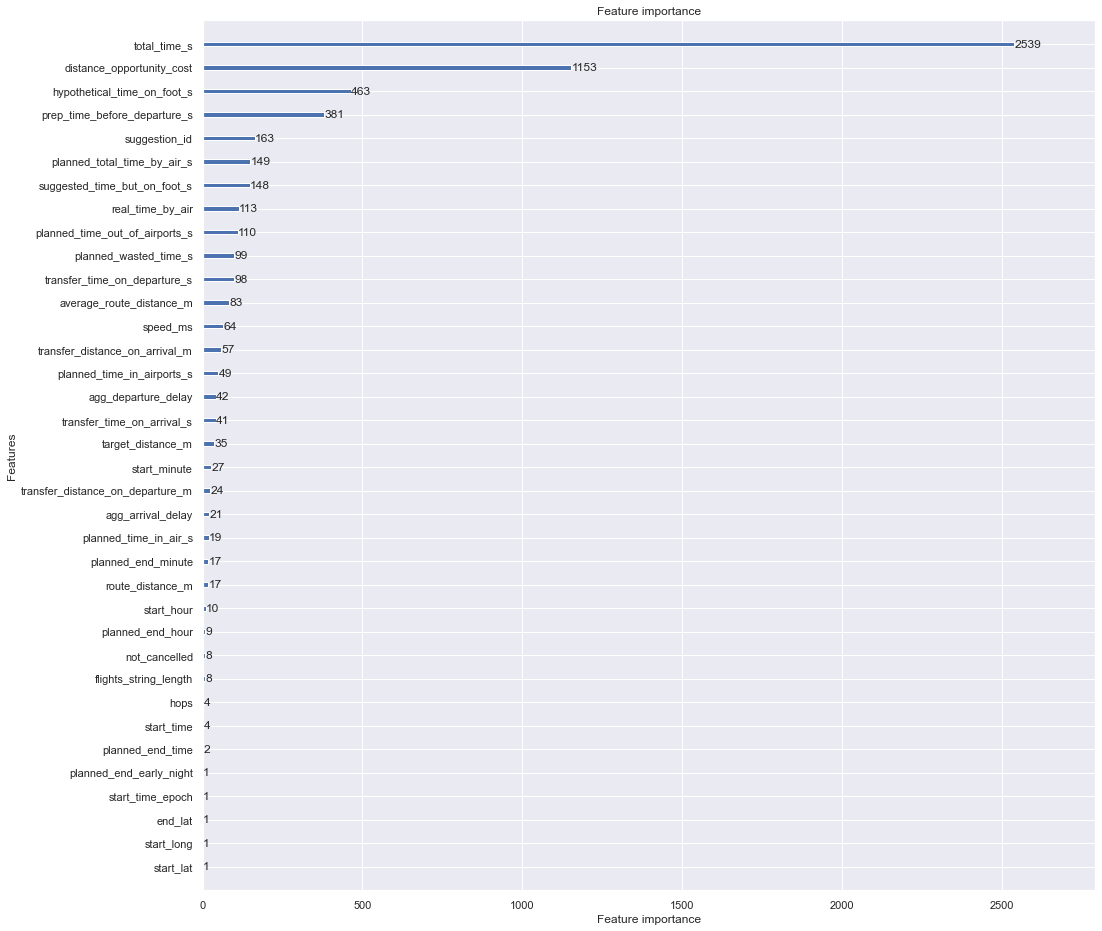

In [605]:
plt.figure(dpi=300)
lgb.plot_importance(gbm, figsize=(16, 16))
plt.show()

In [606]:
%%time
y_predict = gbm.predict(X_test)

CPU times: user 34 s, sys: 629 ms, total: 34.6 s
Wall time: 34.7 s


In [607]:
submit = X_test.copy()

In [608]:
submit["relevance"] = y_predict

In [609]:
submit.sort_values(by=['query_id', 'relevance'], ascending=[True, False], inplace=True)

In [610]:
submit.loc[:, ["query_id", "suggestion_id", "relevance"]]

,query_id,suggestion_id,relevance
7,0,7,3.515469
6,0,6,-5.369124
5,0,5,-5.380859
9,0,9,-5.638920
2,0,2,-5.890710
...,...,...,...
563638,56363,8,-3.728556
563632,56363,2,-3.775399
563636,56363,6,-3.780263
563634,56363,4,-4.111925


In [611]:
kaggle_answer = pd.DataFrame({'query_id': submit['query_id'],
                             'suggestion_id': submit['suggestion_id']})
kaggle_answer.to_csv('answerV14.csv', index=False)

In [612]:
submit.dtypes

query_id                              int64
suggestion_id                         int64
part_id                               int64
start_lat                           float64
start_long                          float64
end_lat                             float64
end_long                            float64
start_time                            int64
speed_ms                            float64
flights_string_length                 int64
start_weekday                         int64
start_week_of_year                    int64
start_hour                            int64
start_minute                          int64
start_time_epoch                    float64
start_early_night                      bool
hops                                  int64
target_distance_m                   float64
hypothetical_time_on_foot_s         float64
route_distance_m                    float64
average_route_distance_m            float64
suggested_time_but_on_foot_s        float64
transfer_distance_on_departure_m

In [613]:
submit.sort_values(by=['query_id', 'total_time_s'], ascending=[True, True], inplace=True)

In [614]:
submit.loc[:, ["query_id", "suggestion_id", "relevance", "total_time_s"]]

,query_id,suggestion_id,relevance,total_time_s
7,0,7,3.515469,52232.297641
6,0,6,-5.369124,111776.903792
5,0,5,-5.380859,111975.903792
2,0,2,-5.890710,120504.903792
4,0,4,-6.023398,121942.903792
...,...,...,...,...
563639,56363,9,-0.734494,66641.381966
563636,56363,6,-3.780263,94953.203676
563632,56363,2,-3.775399,95292.203676
563638,56363,8,-3.728556,95679.203676


In [615]:
kaggle_answer = pd.DataFrame({'query_id': submit['query_id'],
                             'suggestion_id': submit['suggestion_id']})
kaggle_answer.to_csv('answerV14vanilla.csv', index=False)


## Ensembling

In [616]:
r.seed(4242)
train_ids = np.asarray(
    r.sample(
        list(X["query_id"].unique()),
        round(0.80 * X["query_id"].unique().size),
    )
)
val_ids = np.setdiff1d(X["query_id"].unique(), train_ids)


# without leaks

X_wl_train, y_train = X.loc[X['query_id'].isin(train_ids)], y[X['query_id'].isin(train_ids)]
X_wl_val, y_val = X.loc[X['query_id'].isin(val_ids)], y.loc[X['query_id'].isin(val_ids)]
train_queries = list(Counter(np.asarray(X_wl_train['query_id'])).values())
val_queries = list(Counter(np.asarray(X_wl_val['query_id'])).values())

X_wl_train = X_wl_train.set_index(["query_id", "suggestion_id", "part_id"])
X_wl_val = X_wl_val.set_index(["query_id", "suggestion_id", "part_id"])



In [617]:
gbm_wl = lgb.LGBMRanker(
    num_leaves=3,
    n_estimators=3000,
    reg_lambda=1.0,
    min_child_samples=3,
    colsample_bytree=1,
    max_depth=7
)
gbm_wl.fit(
    X_wl_train,
    y_train,
    group=train_queries,
     eval_set=[(X_wl_val, y_val)],
     eval_group=[val_queries],
     eval_at=[10],
     early_stopping_rounds=1000,
)


[1]	valid_0's ndcg@10: 0.662077
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's ndcg@10: 0.688847
[3]	valid_0's ndcg@10: 0.710746
[4]	valid_0's ndcg@10: 0.725525
[5]	valid_0's ndcg@10: 0.733981
[6]	valid_0's ndcg@10: 0.738882
[7]	valid_0's ndcg@10: 0.747678
[8]	valid_0's ndcg@10: 0.752971
[9]	valid_0's ndcg@10: 0.756634
[10]	valid_0's ndcg@10: 0.762324
[11]	valid_0's ndcg@10: 0.767285
[12]	valid_0's ndcg@10: 0.770129
[13]	valid_0's ndcg@10: 0.773514
[14]	valid_0's ndcg@10: 0.775333
[15]	valid_0's ndcg@10: 0.777684
[16]	valid_0's ndcg@10: 0.779567
[17]	valid_0's ndcg@10: 0.78257
[18]	valid_0's ndcg@10: 0.784334
[19]	valid_0's ndcg@10: 0.786357
[20]	valid_0's ndcg@10: 0.788279
[21]	valid_0's ndcg@10: 0.790791
[22]	valid_0's ndcg@10: 0.792094
[23]	valid_0's ndcg@10: 0.794667
[24]	valid_0's ndcg@10: 0.796323
[25]	valid_0's ndcg@10: 0.797178
[26]	valid_0's ndcg@10: 0.79851
[27]	valid_0's ndcg@10: 0.800829
[28]	valid_0's ndcg@10: 0.801929
[29]	valid_0's ndcg@10: 

[246]	valid_0's ndcg@10: 0.870597
[247]	valid_0's ndcg@10: 0.870638
[248]	valid_0's ndcg@10: 0.870569
[249]	valid_0's ndcg@10: 0.870757
[250]	valid_0's ndcg@10: 0.870773
[251]	valid_0's ndcg@10: 0.871003
[252]	valid_0's ndcg@10: 0.87119
[253]	valid_0's ndcg@10: 0.871281
[254]	valid_0's ndcg@10: 0.871192
[255]	valid_0's ndcg@10: 0.871263
[256]	valid_0's ndcg@10: 0.871328
[257]	valid_0's ndcg@10: 0.871374
[258]	valid_0's ndcg@10: 0.871323
[259]	valid_0's ndcg@10: 0.87144
[260]	valid_0's ndcg@10: 0.871922
[261]	valid_0's ndcg@10: 0.871837
[262]	valid_0's ndcg@10: 0.87187
[263]	valid_0's ndcg@10: 0.871959
[264]	valid_0's ndcg@10: 0.872315
[265]	valid_0's ndcg@10: 0.872217
[266]	valid_0's ndcg@10: 0.87218
[267]	valid_0's ndcg@10: 0.872321
[268]	valid_0's ndcg@10: 0.872365
[269]	valid_0's ndcg@10: 0.872348
[270]	valid_0's ndcg@10: 0.872554
[271]	valid_0's ndcg@10: 0.87258
[272]	valid_0's ndcg@10: 0.872571
[273]	valid_0's ndcg@10: 0.872681
[274]	valid_0's ndcg@10: 0.872692
[275]	valid_0's ndc

[489]	valid_0's ndcg@10: 0.881947
[490]	valid_0's ndcg@10: 0.881962
[491]	valid_0's ndcg@10: 0.88198
[492]	valid_0's ndcg@10: 0.882095
[493]	valid_0's ndcg@10: 0.882087
[494]	valid_0's ndcg@10: 0.881999
[495]	valid_0's ndcg@10: 0.882018
[496]	valid_0's ndcg@10: 0.882239
[497]	valid_0's ndcg@10: 0.882182
[498]	valid_0's ndcg@10: 0.882188
[499]	valid_0's ndcg@10: 0.882191
[500]	valid_0's ndcg@10: 0.88235
[501]	valid_0's ndcg@10: 0.882351
[502]	valid_0's ndcg@10: 0.882342
[503]	valid_0's ndcg@10: 0.882393
[504]	valid_0's ndcg@10: 0.882347
[505]	valid_0's ndcg@10: 0.882396
[506]	valid_0's ndcg@10: 0.882587
[507]	valid_0's ndcg@10: 0.88257
[508]	valid_0's ndcg@10: 0.882424
[509]	valid_0's ndcg@10: 0.882409
[510]	valid_0's ndcg@10: 0.882442
[511]	valid_0's ndcg@10: 0.882486
[512]	valid_0's ndcg@10: 0.882586
[513]	valid_0's ndcg@10: 0.882682
[514]	valid_0's ndcg@10: 0.882781
[515]	valid_0's ndcg@10: 0.882783
[516]	valid_0's ndcg@10: 0.88299
[517]	valid_0's ndcg@10: 0.883027
[518]	valid_0's nd

[735]	valid_0's ndcg@10: 0.886467
[736]	valid_0's ndcg@10: 0.886468
[737]	valid_0's ndcg@10: 0.886471
[738]	valid_0's ndcg@10: 0.88647
[739]	valid_0's ndcg@10: 0.886475
[740]	valid_0's ndcg@10: 0.886477
[741]	valid_0's ndcg@10: 0.886531
[742]	valid_0's ndcg@10: 0.886547
[743]	valid_0's ndcg@10: 0.886546
[744]	valid_0's ndcg@10: 0.886654
[745]	valid_0's ndcg@10: 0.886606
[746]	valid_0's ndcg@10: 0.886667
[747]	valid_0's ndcg@10: 0.886664
[748]	valid_0's ndcg@10: 0.886732
[749]	valid_0's ndcg@10: 0.886667
[750]	valid_0's ndcg@10: 0.886725
[751]	valid_0's ndcg@10: 0.886728
[752]	valid_0's ndcg@10: 0.886728
[753]	valid_0's ndcg@10: 0.886797
[754]	valid_0's ndcg@10: 0.88674
[755]	valid_0's ndcg@10: 0.886755
[756]	valid_0's ndcg@10: 0.88679
[757]	valid_0's ndcg@10: 0.88689
[758]	valid_0's ndcg@10: 0.886963
[759]	valid_0's ndcg@10: 0.887016
[760]	valid_0's ndcg@10: 0.887007
[761]	valid_0's ndcg@10: 0.887048
[762]	valid_0's ndcg@10: 0.887057
[763]	valid_0's ndcg@10: 0.887062
[764]	valid_0's nd

[982]	valid_0's ndcg@10: 0.889762
[983]	valid_0's ndcg@10: 0.889762
[984]	valid_0's ndcg@10: 0.889739
[985]	valid_0's ndcg@10: 0.889791
[986]	valid_0's ndcg@10: 0.889785
[987]	valid_0's ndcg@10: 0.889881
[988]	valid_0's ndcg@10: 0.889944
[989]	valid_0's ndcg@10: 0.889915
[990]	valid_0's ndcg@10: 0.889958
[991]	valid_0's ndcg@10: 0.889989
[992]	valid_0's ndcg@10: 0.889954
[993]	valid_0's ndcg@10: 0.889953
[994]	valid_0's ndcg@10: 0.889954
[995]	valid_0's ndcg@10: 0.889969
[996]	valid_0's ndcg@10: 0.890003
[997]	valid_0's ndcg@10: 0.889962
[998]	valid_0's ndcg@10: 0.890067
[999]	valid_0's ndcg@10: 0.890058
[1000]	valid_0's ndcg@10: 0.890052
[1001]	valid_0's ndcg@10: 0.890053
[1002]	valid_0's ndcg@10: 0.890045
[1003]	valid_0's ndcg@10: 0.88998
[1004]	valid_0's ndcg@10: 0.890048
[1005]	valid_0's ndcg@10: 0.890258
[1006]	valid_0's ndcg@10: 0.890279
[1007]	valid_0's ndcg@10: 0.890334
[1008]	valid_0's ndcg@10: 0.890341
[1009]	valid_0's ndcg@10: 0.890359
[1010]	valid_0's ndcg@10: 0.890354
[101

[1218]	valid_0's ndcg@10: 0.89173
[1219]	valid_0's ndcg@10: 0.891766
[1220]	valid_0's ndcg@10: 0.891831
[1221]	valid_0's ndcg@10: 0.89185
[1222]	valid_0's ndcg@10: 0.89185
[1223]	valid_0's ndcg@10: 0.89186
[1224]	valid_0's ndcg@10: 0.89186
[1225]	valid_0's ndcg@10: 0.8919
[1226]	valid_0's ndcg@10: 0.891834
[1227]	valid_0's ndcg@10: 0.891833
[1228]	valid_0's ndcg@10: 0.891916
[1229]	valid_0's ndcg@10: 0.891925
[1230]	valid_0's ndcg@10: 0.891913
[1231]	valid_0's ndcg@10: 0.891914
[1232]	valid_0's ndcg@10: 0.891934
[1233]	valid_0's ndcg@10: 0.891906
[1234]	valid_0's ndcg@10: 0.891926
[1235]	valid_0's ndcg@10: 0.891945
[1236]	valid_0's ndcg@10: 0.892
[1237]	valid_0's ndcg@10: 0.892003
[1238]	valid_0's ndcg@10: 0.892003
[1239]	valid_0's ndcg@10: 0.892003
[1240]	valid_0's ndcg@10: 0.892022
[1241]	valid_0's ndcg@10: 0.891981
[1242]	valid_0's ndcg@10: 0.891981
[1243]	valid_0's ndcg@10: 0.891984
[1244]	valid_0's ndcg@10: 0.891985
[1245]	valid_0's ndcg@10: 0.891981
[1246]	valid_0's ndcg@10: 0.89

[1454]	valid_0's ndcg@10: 0.893664
[1455]	valid_0's ndcg@10: 0.89367
[1456]	valid_0's ndcg@10: 0.893684
[1457]	valid_0's ndcg@10: 0.893711
[1458]	valid_0's ndcg@10: 0.893711
[1459]	valid_0's ndcg@10: 0.893711
[1460]	valid_0's ndcg@10: 0.893761
[1461]	valid_0's ndcg@10: 0.893797
[1462]	valid_0's ndcg@10: 0.893795
[1463]	valid_0's ndcg@10: 0.893795
[1464]	valid_0's ndcg@10: 0.893798
[1465]	valid_0's ndcg@10: 0.893798
[1466]	valid_0's ndcg@10: 0.8938
[1467]	valid_0's ndcg@10: 0.8938
[1468]	valid_0's ndcg@10: 0.893801
[1469]	valid_0's ndcg@10: 0.893835
[1470]	valid_0's ndcg@10: 0.893835
[1471]	valid_0's ndcg@10: 0.893852
[1472]	valid_0's ndcg@10: 0.893852
[1473]	valid_0's ndcg@10: 0.893852
[1474]	valid_0's ndcg@10: 0.893864
[1475]	valid_0's ndcg@10: 0.893866
[1476]	valid_0's ndcg@10: 0.893866
[1477]	valid_0's ndcg@10: 0.893896
[1478]	valid_0's ndcg@10: 0.893946
[1479]	valid_0's ndcg@10: 0.893942
[1480]	valid_0's ndcg@10: 0.89391
[1481]	valid_0's ndcg@10: 0.894015
[1482]	valid_0's ndcg@10: 

[1691]	valid_0's ndcg@10: 0.895531
[1692]	valid_0's ndcg@10: 0.895587
[1693]	valid_0's ndcg@10: 0.895583
[1694]	valid_0's ndcg@10: 0.895642
[1695]	valid_0's ndcg@10: 0.895574
[1696]	valid_0's ndcg@10: 0.895588
[1697]	valid_0's ndcg@10: 0.89561
[1698]	valid_0's ndcg@10: 0.89565
[1699]	valid_0's ndcg@10: 0.895649
[1700]	valid_0's ndcg@10: 0.895717
[1701]	valid_0's ndcg@10: 0.895717
[1702]	valid_0's ndcg@10: 0.895721
[1703]	valid_0's ndcg@10: 0.895727
[1704]	valid_0's ndcg@10: 0.895821
[1705]	valid_0's ndcg@10: 0.89584
[1706]	valid_0's ndcg@10: 0.895795
[1707]	valid_0's ndcg@10: 0.895807
[1708]	valid_0's ndcg@10: 0.895777
[1709]	valid_0's ndcg@10: 0.895777
[1710]	valid_0's ndcg@10: 0.89578
[1711]	valid_0's ndcg@10: 0.89578
[1712]	valid_0's ndcg@10: 0.895782
[1713]	valid_0's ndcg@10: 0.895788
[1714]	valid_0's ndcg@10: 0.895809
[1715]	valid_0's ndcg@10: 0.895809
[1716]	valid_0's ndcg@10: 0.895823
[1717]	valid_0's ndcg@10: 0.895823
[1718]	valid_0's ndcg@10: 0.895809
[1719]	valid_0's ndcg@10:

[1932]	valid_0's ndcg@10: 0.896372
[1933]	valid_0's ndcg@10: 0.896429
[1934]	valid_0's ndcg@10: 0.896434
[1935]	valid_0's ndcg@10: 0.896434
[1936]	valid_0's ndcg@10: 0.896429
[1937]	valid_0's ndcg@10: 0.896424
[1938]	valid_0's ndcg@10: 0.896432
[1939]	valid_0's ndcg@10: 0.896429
[1940]	valid_0's ndcg@10: 0.896441
[1941]	valid_0's ndcg@10: 0.896598
[1942]	valid_0's ndcg@10: 0.896683
[1943]	valid_0's ndcg@10: 0.896586
[1944]	valid_0's ndcg@10: 0.896584
[1945]	valid_0's ndcg@10: 0.896563
[1946]	valid_0's ndcg@10: 0.896614
[1947]	valid_0's ndcg@10: 0.896614
[1948]	valid_0's ndcg@10: 0.896562
[1949]	valid_0's ndcg@10: 0.896562
[1950]	valid_0's ndcg@10: 0.896554
[1951]	valid_0's ndcg@10: 0.896596
[1952]	valid_0's ndcg@10: 0.8965
[1953]	valid_0's ndcg@10: 0.896492
[1954]	valid_0's ndcg@10: 0.896574
[1955]	valid_0's ndcg@10: 0.896659
[1956]	valid_0's ndcg@10: 0.89667
[1957]	valid_0's ndcg@10: 0.89666
[1958]	valid_0's ndcg@10: 0.896652
[1959]	valid_0's ndcg@10: 0.896648
[1960]	valid_0's ndcg@10

[2167]	valid_0's ndcg@10: 0.897755
[2168]	valid_0's ndcg@10: 0.897713
[2169]	valid_0's ndcg@10: 0.89771
[2170]	valid_0's ndcg@10: 0.89776
[2171]	valid_0's ndcg@10: 0.897332
[2172]	valid_0's ndcg@10: 0.897244
[2173]	valid_0's ndcg@10: 0.897244
[2174]	valid_0's ndcg@10: 0.897326
[2175]	valid_0's ndcg@10: 0.897477
[2176]	valid_0's ndcg@10: 0.897488
[2177]	valid_0's ndcg@10: 0.897495
[2178]	valid_0's ndcg@10: 0.897496
[2179]	valid_0's ndcg@10: 0.897496
[2180]	valid_0's ndcg@10: 0.897494
[2181]	valid_0's ndcg@10: 0.897533
[2182]	valid_0's ndcg@10: 0.897521
[2183]	valid_0's ndcg@10: 0.89752
[2184]	valid_0's ndcg@10: 0.89752
[2185]	valid_0's ndcg@10: 0.897493
[2186]	valid_0's ndcg@10: 0.897492
[2187]	valid_0's ndcg@10: 0.897497
[2188]	valid_0's ndcg@10: 0.897501
[2189]	valid_0's ndcg@10: 0.897504
[2190]	valid_0's ndcg@10: 0.897505
[2191]	valid_0's ndcg@10: 0.897495
[2192]	valid_0's ndcg@10: 0.897497
[2193]	valid_0's ndcg@10: 0.897493
[2194]	valid_0's ndcg@10: 0.897495
[2195]	valid_0's ndcg@10

[2403]	valid_0's ndcg@10: 0.898412
[2404]	valid_0's ndcg@10: 0.898413
[2405]	valid_0's ndcg@10: 0.898411
[2406]	valid_0's ndcg@10: 0.898411
[2407]	valid_0's ndcg@10: 0.898411
[2408]	valid_0's ndcg@10: 0.898411
[2409]	valid_0's ndcg@10: 0.898427
[2410]	valid_0's ndcg@10: 0.898412
[2411]	valid_0's ndcg@10: 0.898412
[2412]	valid_0's ndcg@10: 0.898412
[2413]	valid_0's ndcg@10: 0.898411
[2414]	valid_0's ndcg@10: 0.898404
[2415]	valid_0's ndcg@10: 0.89843
[2416]	valid_0's ndcg@10: 0.898429
[2417]	valid_0's ndcg@10: 0.898429
[2418]	valid_0's ndcg@10: 0.898429
[2419]	valid_0's ndcg@10: 0.898429
[2420]	valid_0's ndcg@10: 0.89845
[2421]	valid_0's ndcg@10: 0.89845
[2422]	valid_0's ndcg@10: 0.898421
[2423]	valid_0's ndcg@10: 0.898381
[2424]	valid_0's ndcg@10: 0.898373
[2425]	valid_0's ndcg@10: 0.898373
[2426]	valid_0's ndcg@10: 0.898373
[2427]	valid_0's ndcg@10: 0.898372
[2428]	valid_0's ndcg@10: 0.89837
[2429]	valid_0's ndcg@10: 0.898369
[2430]	valid_0's ndcg@10: 0.898389
[2431]	valid_0's ndcg@10

[2640]	valid_0's ndcg@10: 0.899069
[2641]	valid_0's ndcg@10: 0.899083
[2642]	valid_0's ndcg@10: 0.899074
[2643]	valid_0's ndcg@10: 0.899089
[2644]	valid_0's ndcg@10: 0.899137
[2645]	valid_0's ndcg@10: 0.899138
[2646]	valid_0's ndcg@10: 0.899141
[2647]	valid_0's ndcg@10: 0.899141
[2648]	valid_0's ndcg@10: 0.89914
[2649]	valid_0's ndcg@10: 0.899041
[2650]	valid_0's ndcg@10: 0.899088
[2651]	valid_0's ndcg@10: 0.899134
[2652]	valid_0's ndcg@10: 0.899135
[2653]	valid_0's ndcg@10: 0.899154
[2654]	valid_0's ndcg@10: 0.89918
[2655]	valid_0's ndcg@10: 0.89917
[2656]	valid_0's ndcg@10: 0.89917
[2657]	valid_0's ndcg@10: 0.899172
[2658]	valid_0's ndcg@10: 0.899171
[2659]	valid_0's ndcg@10: 0.899233
[2660]	valid_0's ndcg@10: 0.89919
[2661]	valid_0's ndcg@10: 0.899169
[2662]	valid_0's ndcg@10: 0.899254
[2663]	valid_0's ndcg@10: 0.899256
[2664]	valid_0's ndcg@10: 0.899257
[2665]	valid_0's ndcg@10: 0.899264
[2666]	valid_0's ndcg@10: 0.899271
[2667]	valid_0's ndcg@10: 0.899268
[2668]	valid_0's ndcg@10:

[2878]	valid_0's ndcg@10: 0.89924
[2879]	valid_0's ndcg@10: 0.89924
[2880]	valid_0's ndcg@10: 0.899251
[2881]	valid_0's ndcg@10: 0.899249
[2882]	valid_0's ndcg@10: 0.899249
[2883]	valid_0's ndcg@10: 0.89925
[2884]	valid_0's ndcg@10: 0.899252
[2885]	valid_0's ndcg@10: 0.899251
[2886]	valid_0's ndcg@10: 0.899254
[2887]	valid_0's ndcg@10: 0.899255
[2888]	valid_0's ndcg@10: 0.899255
[2889]	valid_0's ndcg@10: 0.89926
[2890]	valid_0's ndcg@10: 0.89926
[2891]	valid_0's ndcg@10: 0.899261
[2892]	valid_0's ndcg@10: 0.899248
[2893]	valid_0's ndcg@10: 0.899248
[2894]	valid_0's ndcg@10: 0.899246
[2895]	valid_0's ndcg@10: 0.89921
[2896]	valid_0's ndcg@10: 0.89921
[2897]	valid_0's ndcg@10: 0.89921
[2898]	valid_0's ndcg@10: 0.89921
[2899]	valid_0's ndcg@10: 0.899213
[2900]	valid_0's ndcg@10: 0.899187
[2901]	valid_0's ndcg@10: 0.899201
[2902]	valid_0's ndcg@10: 0.899148
[2903]	valid_0's ndcg@10: 0.899143
[2904]	valid_0's ndcg@10: 0.899103
[2905]	valid_0's ndcg@10: 0.899105
[2906]	valid_0's ndcg@10: 0.8

LGBMRanker(colsample_bytree=1, max_depth=7, min_child_samples=3,
           n_estimators=3000, num_leaves=3, reg_lambda=1.0)

In [618]:
gbm_wl.booster_.save_model("rankingModelWL.lgb")


### Predictions for the ensemble

In [2]:
schedule

NameError: name 'schedule' is not defined

In [619]:
r.seed(424242)
train_ids = np.asarray(
    r.sample(
        list(X["query_id"].unique()),
        round(0.80 * X["query_id"].unique().size),
    )
)
val_ids = np.setdiff1d(X["query_id"].unique(), train_ids)


# without leaks

X_train, y_train = X.loc[X['query_id'].isin(train_ids)], y[X['query_id'].isin(train_ids)]
X_val, y_val = X.loc[X['query_id'].isin(val_ids)], y.loc[X['query_id'].isin(val_ids)]
train_queries = list(Counter(np.asarray(X_train['query_id'])).values())
val_queries = list(Counter(np.asarray(X_val['query_id'])).values())

In [638]:
def aug_ens(df):
    df = df.copy()
    df_wl = df.set_index(["query_id", "suggestion_id", "part_id"])
    
#     df.loc[:, "relevance_v14"] = gbm.predict(df)
    df.loc[:, "relevance_wl_v14"] = gbm_wl.predict(df_wl)
    df.loc[:, "relevance_total_time"] = df.groupby(["query_id"])["total_time_s"].rank(
        "dense", ascending=True
    )
    df.loc[:, "planned_end_time"] = df.groupby(["query_id"])["planned_end_time"].rank(
        "dense", ascending=True
    )
    df.loc[:, "real_time_by_air"] = df.groupby(["query_id"])["real_time_by_air"].rank(
        "dense", ascending=True
    )
    return df.loc[
        :,
        [
#             "relevance_v14",
            "relevance_wl_v14",
            "relevance_total_time",
            "planned_end_time",
            "real_time_by_air",
        ],
    ]

In [639]:
X_ens_train = aug_ens(X_train)
X_ens_val = aug_ens(X_val)

In [640]:
gbm_ens = lgb.LGBMRanker(
    num_leaves=3,
    n_estimators=3000,
    reg_lambda=1.0,
    min_child_samples=3,
    colsample_bytree=1,
    max_depth=7
)
gbm_ens.fit(
    X_ens_train,
    y_train,
    group=train_queries,
     eval_set=[(X_ens_val, y_val)],
     eval_group=[val_queries],
     eval_at=[10],
     early_stopping_rounds=400,
)


[1]	valid_0's ndcg@10: 0.856415
Training until validation scores don't improve for 400 rounds
[2]	valid_0's ndcg@10: 0.910443
[3]	valid_0's ndcg@10: 0.916768
[4]	valid_0's ndcg@10: 0.917277
[5]	valid_0's ndcg@10: 0.917317
[6]	valid_0's ndcg@10: 0.917317
[7]	valid_0's ndcg@10: 0.917317
[8]	valid_0's ndcg@10: 0.917317
[9]	valid_0's ndcg@10: 0.917798
[10]	valid_0's ndcg@10: 0.917798
[11]	valid_0's ndcg@10: 0.917772
[12]	valid_0's ndcg@10: 0.917798
[13]	valid_0's ndcg@10: 0.917715
[14]	valid_0's ndcg@10: 0.917772
[15]	valid_0's ndcg@10: 0.917798
[16]	valid_0's ndcg@10: 0.917715
[17]	valid_0's ndcg@10: 0.917141
[18]	valid_0's ndcg@10: 0.917911
[19]	valid_0's ndcg@10: 0.917911
[20]	valid_0's ndcg@10: 0.917911
[21]	valid_0's ndcg@10: 0.917911
[22]	valid_0's ndcg@10: 0.917911
[23]	valid_0's ndcg@10: 0.917305
[24]	valid_0's ndcg@10: 0.917911
[25]	valid_0's ndcg@10: 0.917879
[26]	valid_0's ndcg@10: 0.917879
[27]	valid_0's ndcg@10: 0.917879
[28]	valid_0's ndcg@10: 0.917879
[29]	valid_0's ndcg@10:

[245]	valid_0's ndcg@10: 0.917795
[246]	valid_0's ndcg@10: 0.917814
[247]	valid_0's ndcg@10: 0.917817
[248]	valid_0's ndcg@10: 0.917817
[249]	valid_0's ndcg@10: 0.917817
[250]	valid_0's ndcg@10: 0.917785
[251]	valid_0's ndcg@10: 0.917812
[252]	valid_0's ndcg@10: 0.917798
[253]	valid_0's ndcg@10: 0.917781
[254]	valid_0's ndcg@10: 0.917782
[255]	valid_0's ndcg@10: 0.917782
[256]	valid_0's ndcg@10: 0.917783
[257]	valid_0's ndcg@10: 0.917783
[258]	valid_0's ndcg@10: 0.917783
[259]	valid_0's ndcg@10: 0.917773
[260]	valid_0's ndcg@10: 0.917773
[261]	valid_0's ndcg@10: 0.917772
[262]	valid_0's ndcg@10: 0.917774
[263]	valid_0's ndcg@10: 0.917747
[264]	valid_0's ndcg@10: 0.91774
[265]	valid_0's ndcg@10: 0.917742
[266]	valid_0's ndcg@10: 0.917733
[267]	valid_0's ndcg@10: 0.917734
[268]	valid_0's ndcg@10: 0.917734
[269]	valid_0's ndcg@10: 0.91776
[270]	valid_0's ndcg@10: 0.917761
[271]	valid_0's ndcg@10: 0.917761
[272]	valid_0's ndcg@10: 0.917752
[273]	valid_0's ndcg@10: 0.91778
[274]	valid_0's n

[490]	valid_0's ndcg@10: 0.918343
[491]	valid_0's ndcg@10: 0.918625
[492]	valid_0's ndcg@10: 0.918635
[493]	valid_0's ndcg@10: 0.918635
[494]	valid_0's ndcg@10: 0.918635
[495]	valid_0's ndcg@10: 0.918629
[496]	valid_0's ndcg@10: 0.918627
[497]	valid_0's ndcg@10: 0.918627
[498]	valid_0's ndcg@10: 0.918627
[499]	valid_0's ndcg@10: 0.918632
[500]	valid_0's ndcg@10: 0.918632
[501]	valid_0's ndcg@10: 0.918633
[502]	valid_0's ndcg@10: 0.918632
[503]	valid_0's ndcg@10: 0.91863
[504]	valid_0's ndcg@10: 0.918631
[505]	valid_0's ndcg@10: 0.918649
[506]	valid_0's ndcg@10: 0.918648
[507]	valid_0's ndcg@10: 0.918649
[508]	valid_0's ndcg@10: 0.918376
[509]	valid_0's ndcg@10: 0.91848
[510]	valid_0's ndcg@10: 0.918473
[511]	valid_0's ndcg@10: 0.918474
[512]	valid_0's ndcg@10: 0.918474
[513]	valid_0's ndcg@10: 0.918474
[514]	valid_0's ndcg@10: 0.918526
[515]	valid_0's ndcg@10: 0.918526
[516]	valid_0's ndcg@10: 0.918526
[517]	valid_0's ndcg@10: 0.918526
[518]	valid_0's ndcg@10: 0.918488
[519]	valid_0's 

[732]	valid_0's ndcg@10: 0.918978
[733]	valid_0's ndcg@10: 0.918945
[734]	valid_0's ndcg@10: 0.918945
[735]	valid_0's ndcg@10: 0.918925
[736]	valid_0's ndcg@10: 0.918957
[737]	valid_0's ndcg@10: 0.918957
[738]	valid_0's ndcg@10: 0.918958
[739]	valid_0's ndcg@10: 0.918958
[740]	valid_0's ndcg@10: 0.91896
[741]	valid_0's ndcg@10: 0.918956
[742]	valid_0's ndcg@10: 0.918956
[743]	valid_0's ndcg@10: 0.919003
[744]	valid_0's ndcg@10: 0.91901
[745]	valid_0's ndcg@10: 0.919011
[746]	valid_0's ndcg@10: 0.919011
[747]	valid_0's ndcg@10: 0.919021
[748]	valid_0's ndcg@10: 0.919044
[749]	valid_0's ndcg@10: 0.919028
[750]	valid_0's ndcg@10: 0.919029
[751]	valid_0's ndcg@10: 0.919017
[752]	valid_0's ndcg@10: 0.919037
[753]	valid_0's ndcg@10: 0.919032
[754]	valid_0's ndcg@10: 0.919154
[755]	valid_0's ndcg@10: 0.919154
[756]	valid_0's ndcg@10: 0.919153
[757]	valid_0's ndcg@10: 0.91917
[758]	valid_0's ndcg@10: 0.919079
[759]	valid_0's ndcg@10: 0.91918
[760]	valid_0's ndcg@10: 0.919072
[761]	valid_0's nd

[982]	valid_0's ndcg@10: 0.919213
[983]	valid_0's ndcg@10: 0.919192
[984]	valid_0's ndcg@10: 0.919208
[985]	valid_0's ndcg@10: 0.919209
[986]	valid_0's ndcg@10: 0.919209
[987]	valid_0's ndcg@10: 0.919208
[988]	valid_0's ndcg@10: 0.919187
[989]	valid_0's ndcg@10: 0.919192
[990]	valid_0's ndcg@10: 0.919209
[991]	valid_0's ndcg@10: 0.919208
[992]	valid_0's ndcg@10: 0.919206
[993]	valid_0's ndcg@10: 0.919205
[994]	valid_0's ndcg@10: 0.919205
[995]	valid_0's ndcg@10: 0.919206
[996]	valid_0's ndcg@10: 0.919206
[997]	valid_0's ndcg@10: 0.919266
[998]	valid_0's ndcg@10: 0.919212
[999]	valid_0's ndcg@10: 0.919208
[1000]	valid_0's ndcg@10: 0.919214
[1001]	valid_0's ndcg@10: 0.919211
[1002]	valid_0's ndcg@10: 0.919211
[1003]	valid_0's ndcg@10: 0.919211
[1004]	valid_0's ndcg@10: 0.919239
[1005]	valid_0's ndcg@10: 0.919239
[1006]	valid_0's ndcg@10: 0.919213
[1007]	valid_0's ndcg@10: 0.919297
[1008]	valid_0's ndcg@10: 0.919299
[1009]	valid_0's ndcg@10: 0.919308
[1010]	valid_0's ndcg@10: 0.919295
[10

[1218]	valid_0's ndcg@10: 0.919321
[1219]	valid_0's ndcg@10: 0.919325
[1220]	valid_0's ndcg@10: 0.919325
[1221]	valid_0's ndcg@10: 0.919272
[1222]	valid_0's ndcg@10: 0.919269
[1223]	valid_0's ndcg@10: 0.919265
[1224]	valid_0's ndcg@10: 0.919266
[1225]	valid_0's ndcg@10: 0.919266
[1226]	valid_0's ndcg@10: 0.919267
[1227]	valid_0's ndcg@10: 0.919267
[1228]	valid_0's ndcg@10: 0.919266
[1229]	valid_0's ndcg@10: 0.919267
[1230]	valid_0's ndcg@10: 0.919268
[1231]	valid_0's ndcg@10: 0.919268
[1232]	valid_0's ndcg@10: 0.919267
[1233]	valid_0's ndcg@10: 0.919277
[1234]	valid_0's ndcg@10: 0.919267
[1235]	valid_0's ndcg@10: 0.919271
[1236]	valid_0's ndcg@10: 0.919275
[1237]	valid_0's ndcg@10: 0.919277
[1238]	valid_0's ndcg@10: 0.919276
[1239]	valid_0's ndcg@10: 0.919276
[1240]	valid_0's ndcg@10: 0.919282
[1241]	valid_0's ndcg@10: 0.919282
[1242]	valid_0's ndcg@10: 0.919282
[1243]	valid_0's ndcg@10: 0.91929
[1244]	valid_0's ndcg@10: 0.919277
[1245]	valid_0's ndcg@10: 0.919277
[1246]	valid_0's ndcg

[1455]	valid_0's ndcg@10: 0.919219
[1456]	valid_0's ndcg@10: 0.919216
[1457]	valid_0's ndcg@10: 0.91922
[1458]	valid_0's ndcg@10: 0.919218
[1459]	valid_0's ndcg@10: 0.919217
[1460]	valid_0's ndcg@10: 0.919217
[1461]	valid_0's ndcg@10: 0.919217
[1462]	valid_0's ndcg@10: 0.919217
[1463]	valid_0's ndcg@10: 0.919217
[1464]	valid_0's ndcg@10: 0.919217
[1465]	valid_0's ndcg@10: 0.919217
[1466]	valid_0's ndcg@10: 0.919231
[1467]	valid_0's ndcg@10: 0.919231
[1468]	valid_0's ndcg@10: 0.919231
[1469]	valid_0's ndcg@10: 0.919231
[1470]	valid_0's ndcg@10: 0.919234
[1471]	valid_0's ndcg@10: 0.919234
[1472]	valid_0's ndcg@10: 0.919232
[1473]	valid_0's ndcg@10: 0.919225
[1474]	valid_0's ndcg@10: 0.919225
[1475]	valid_0's ndcg@10: 0.919226
[1476]	valid_0's ndcg@10: 0.919226
[1477]	valid_0's ndcg@10: 0.919227
[1478]	valid_0's ndcg@10: 0.919227
[1479]	valid_0's ndcg@10: 0.919227
[1480]	valid_0's ndcg@10: 0.919227
[1481]	valid_0's ndcg@10: 0.919233
[1482]	valid_0's ndcg@10: 0.919233
[1483]	valid_0's ndcg

[1696]	valid_0's ndcg@10: 0.919214
[1697]	valid_0's ndcg@10: 0.919214
[1698]	valid_0's ndcg@10: 0.919216
[1699]	valid_0's ndcg@10: 0.919218
[1700]	valid_0's ndcg@10: 0.91922
[1701]	valid_0's ndcg@10: 0.919228
[1702]	valid_0's ndcg@10: 0.91922
[1703]	valid_0's ndcg@10: 0.91922
[1704]	valid_0's ndcg@10: 0.91922
[1705]	valid_0's ndcg@10: 0.919219
[1706]	valid_0's ndcg@10: 0.91922
[1707]	valid_0's ndcg@10: 0.91922
[1708]	valid_0's ndcg@10: 0.919226
[1709]	valid_0's ndcg@10: 0.919251
[1710]	valid_0's ndcg@10: 0.919256
[1711]	valid_0's ndcg@10: 0.919256
[1712]	valid_0's ndcg@10: 0.919252
[1713]	valid_0's ndcg@10: 0.919252
[1714]	valid_0's ndcg@10: 0.919243
[1715]	valid_0's ndcg@10: 0.919243
[1716]	valid_0's ndcg@10: 0.919234
[1717]	valid_0's ndcg@10: 0.919234
[1718]	valid_0's ndcg@10: 0.919234
[1719]	valid_0's ndcg@10: 0.919239
[1720]	valid_0's ndcg@10: 0.919239
[1721]	valid_0's ndcg@10: 0.919244
[1722]	valid_0's ndcg@10: 0.919239
[1723]	valid_0's ndcg@10: 0.91924
[1724]	valid_0's ndcg@10: 0

LGBMRanker(colsample_bytree=1, max_depth=7, min_child_samples=3,
           n_estimators=3000, num_leaves=3, reg_lambda=1.0)

<Figure size 1800x1200 with 0 Axes>

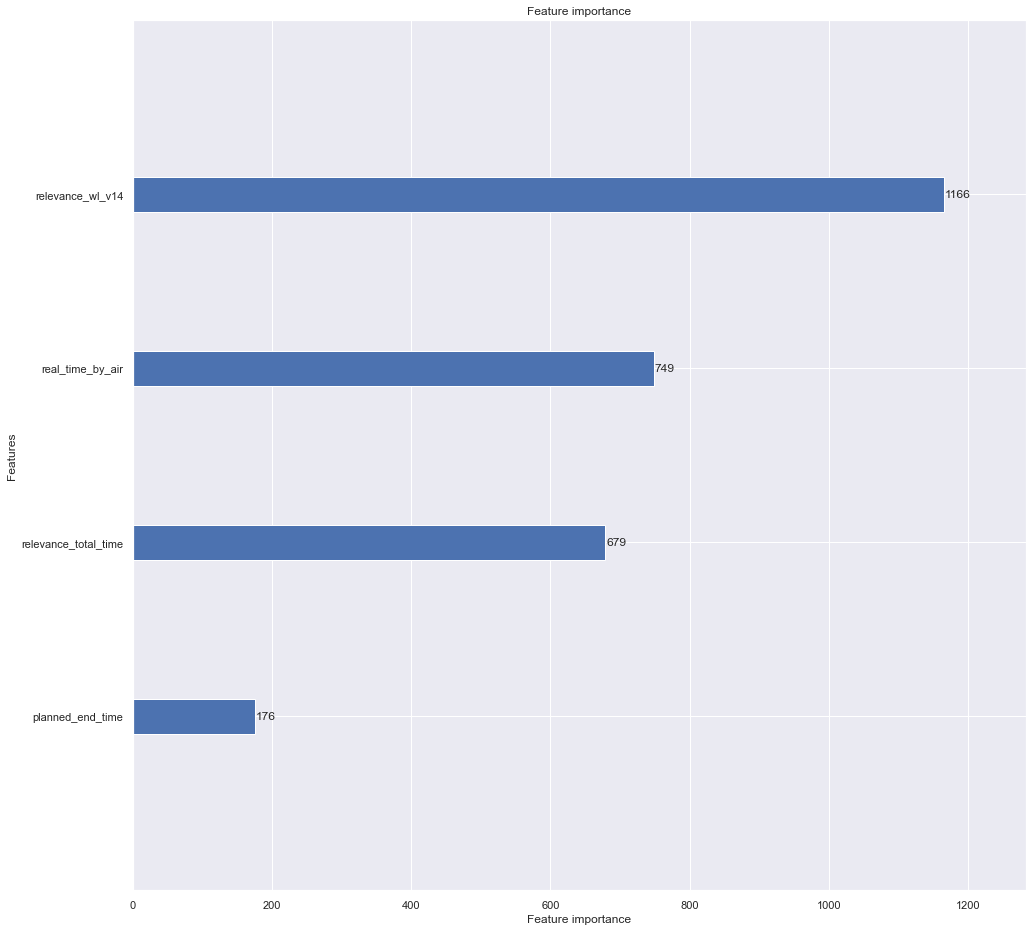

In [641]:
plt.figure(dpi=300)
lgb.plot_importance(gbm_ens, figsize=(16, 16))
plt.show()


In [628]:
gbm_ens.booster_.save_model("rankingModelEns.lgb")

In [642]:
X_ens_test = aug_ens(pd.read_csv("X_test.v14.csv"))

In [659]:
submit = pd.read_csv("X_test.v14.csv")

In [647]:
#submit.loc[:, "ens_relevance"] = gbm_ens.predict(X_ens_test)

In [660]:
submit.dtypes

query_id                              int64
suggestion_id                         int64
part_id                               int64
start_lat                           float64
start_long                          float64
end_lat                             float64
end_long                            float64
start_time                            int64
speed_ms                            float64
flights_string_length                 int64
start_weekday                         int64
start_week_of_year                    int64
start_hour                            int64
start_minute                          int64
start_time_epoch                    float64
start_early_night                      bool
hops                                  int64
target_distance_m                   float64
hypothetical_time_on_foot_s         float64
route_distance_m                    float64
average_route_distance_m            float64
suggested_time_but_on_foot_s        float64
transfer_distance_on_departure_m

In [667]:
submit.sort_values(by=['query_id', 'total_time_s'], ascending=[True, True], inplace=True)


In [668]:
submit.loc[:, ["query_id", "suggestion_id", "total_time_s"]]


,query_id,suggestion_id,total_time_s
7,0,7,52232.297641
6,0,6,111776.903792
5,0,5,111975.903792
2,0,2,120504.903792
4,0,4,121942.903792
...,...,...,...
563639,56363,9,66641.381966
563636,56363,6,94953.203676
563632,56363,2,95292.203676
563638,56363,8,95679.203676


In [669]:
kaggle_answer = pd.DataFrame({'query_id': submit['query_id'],
                             'suggestion_id': submit['suggestion_id']})
kaggle_answer.to_csv('answerV15_vanilla.csv', index=False)


In [652]:
X_wl_train.dtypes

start_lat                           float64
start_long                          float64
end_lat                             float64
end_long                            float64
start_time                            int64
speed_ms                            float64
flights_string_length                 int64
start_weekday                         int64
start_week_of_year                    int64
start_hour                            int64
start_minute                          int64
start_time_epoch                    float64
start_early_night                      bool
hops                                  int64
target_distance_m                   float64
hypothetical_time_on_foot_s         float64
route_distance_m                    float64
average_route_distance_m            float64
suggested_time_but_on_foot_s        float64
transfer_distance_on_departure_m    float64
transfer_time_on_departure_s        float64
prep_time_before_departure_s        float64
transfer_distance_on_arrival_m  

In [654]:
X_test.

,query_id,suggestion_id,part_id,start_lat,start_long,end_lat,end_long,start_time,speed_ms,flights_string_length,...,distance_opportunity_cost,start_weather_type,start_weather_level,end_weather_type,end_weather_level,not_cancelled,cancelled,agg_departure_delay,agg_arrival_delay,real_time_by_air
0,0,0,0,41.670414,-84.014662,45.581950,-103.163676,117241982,11.388889,20,...,1.780879e+06,4,1,0,4,0.814104,False,0.012008,0.010749,156369.903792
1,0,1,0,41.670414,-84.014662,45.581950,-103.163676,117282642,11.388889,20,...,1.418257e+06,4,1,0,4,0.999898,False,0.012008,0.010749,124529.903792
2,0,2,0,41.670414,-84.014662,45.581950,-103.163676,117286667,11.388889,20,...,1.372417e+06,4,1,0,4,0.999898,False,0.012008,0.010749,120504.903792
3,0,3,0,41.670414,-84.014662,45.581950,-103.163676,117282134,11.388889,20,...,1.424043e+06,4,1,0,4,0.999898,False,0.012008,0.010749,125037.903792
4,0,4,0,41.670414,-84.014662,45.581950,-103.163676,117285229,11.388889,20,...,1.388794e+06,4,1,0,4,0.999898,False,0.012008,0.010749,121942.903792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563635,56363,5,7,44.039416,-87.078139,31.487377,-82.549751,144202424,24.166667,20,...,1.213140e+06,4,1,1,4,0.999317,False,0.065042,0.052719,45089.482815
563636,56363,6,7,44.039416,-87.078139,31.487377,-82.549751,144223356,24.166667,30,...,2.294702e+06,4,1,1,4,0.996191,False,0.097563,0.079078,95360.849182
563637,56363,7,7,44.039416,-87.078139,31.487377,-82.549751,144203898,24.166667,20,...,1.177518e+06,4,1,1,4,0.999317,False,0.065042,0.052719,51562.369816
563638,56363,8,7,44.039416,-87.078139,31.487377,-82.549751,144222630,24.166667,30,...,2.312247e+06,4,1,1,4,0.996191,False,0.097563,0.079078,97868.056203


In [ ]:
df = pd.read_csv()
df.loc[:, "relevance_total_time"] = df.groupby(["query_id"])["total_time_s"].rank(
        "dense", ascending=True
    )
